In [ ]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

In [ ]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [ ]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [ ]:
from xgboost import XGBClassifier

In [20]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

In [21]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# Helper functions for model training

In [22]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = pd.DataFrame(np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0))
    


In [23]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [24]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# Exploratory Analysis

### Plotting functions

In [25]:
#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [26]:
import matplotlib.gridspec as gridspec



class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

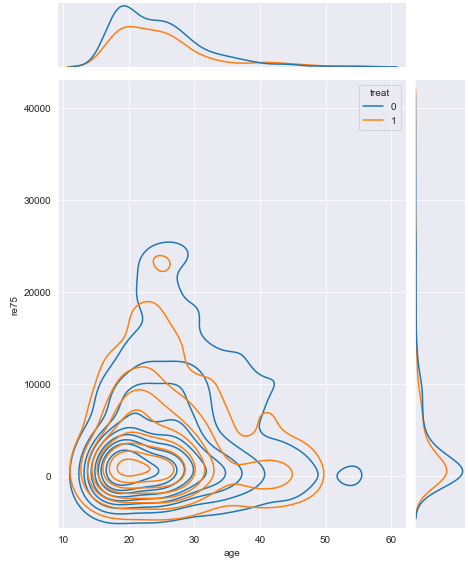

In [27]:
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
#g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
#g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)
##g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)


gs = gridspec.GridSpec(1,4)
fig = plt.figure(figsize=(24,8))

mg0 = SeabornFigToGrid(g0, fig, gs[0])
#mg1 = SeabornFigToGrid(g1, fig, gs[1])
#mg2 = SeabornFigToGrid(g2, fig, gs[2])
#mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)

In [28]:
mg0 = SeabornFigToGrid(g0, fig, gs[0])

In [29]:
nsw[nsw['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,297.0,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.097656,5976.353516
std,0.0,6.686391,1.817712,0.399660,0.292706,0.374808,0.444376,4874.889160,6923.800293
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,549.298401
50%,1.0,23.000000,11.000000,1.000000,0.000000,0.000000,1.000000,1117.438965,4232.309082
75%,1.0,27.000000,12.000000,1.000000,0.000000,0.000000,1.000000,4310.455078,9381.294922
max,1.0,49.000000,16.000000,1.000000,1.000000,1.000000,1.000000,37431.660156,60307.929688


In [30]:
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [31]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [32]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [33]:
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


In [34]:
cps.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,15992.0,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000
mean,0.0,33.225239,12.027514,0.073537,0.072036,0.711731,0.295835,14016.423828,13650.932617,14847.295898
std,0.0,11.045195,2.870768,0.261036,0.258558,0.452951,0.456400,9569.904297,9270.392578,9647.392578
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4403.452393,4398.823242,5669.298096
50%,0.0,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,15123.580078,14557.110352,16421.974609
75%,0.0,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23584.179688,22923.736816,25564.669922
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320312,25243.550781,25564.669922


In [35]:
psid.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,2490.0,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,0.0,34.850601,12.116867,0.250602,0.032530,0.866265,0.305221,19428.792969,19063.324219,21553.917969
std,0.0,10.440774,3.082437,0.433448,0.177438,0.340434,0.460595,13406.878906,13596.924805,15555.367188
min,0.0,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,26.000000,11.000000,0.000000,0.000000,1.000000,0.000000,10775.966797,9846.774414,11526.266602
50%,0.0,33.000000,12.000000,0.000000,0.000000,1.000000,0.000000,18417.107422,17903.226562,20688.171875
75%,0.0,44.000000,14.000000,1.000000,0.000000,1.000000,1.000000,26450.101562,26496.773438,29554.531250
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,137148.687500,156653.234375,121173.578125


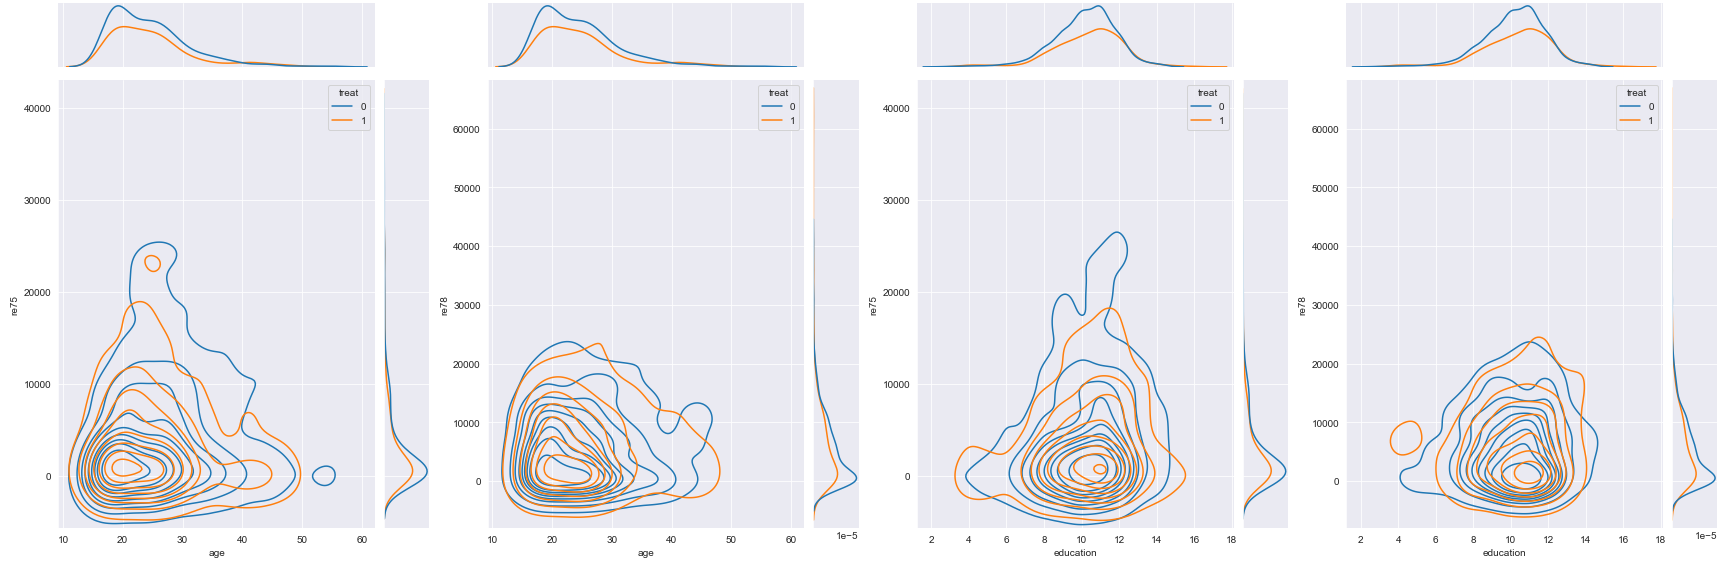

In [36]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


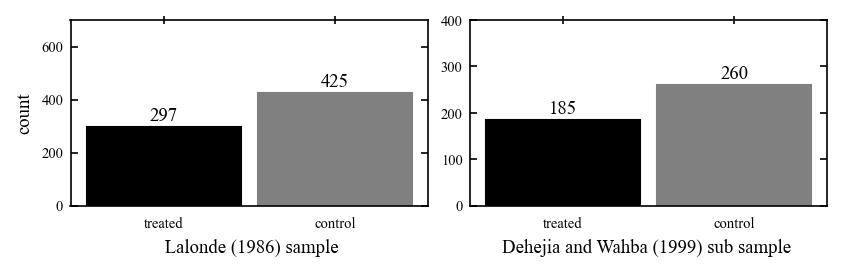

In [42]:
# Plot the balance of classes in the datasets 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix1_wage_boxplots.png'

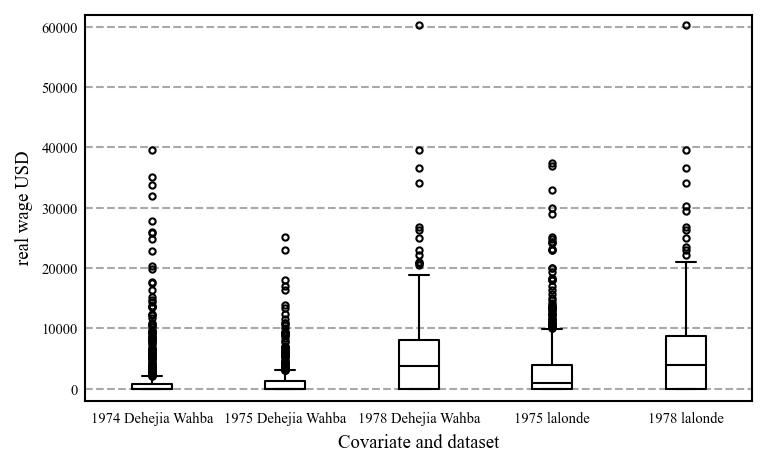

In [43]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['1974 Dehejia Wahba', '1975 Dehejia Wahba','1978 Dehejia Wahba','1975 lalonde','1978 lalonde'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix1_wage_boxplots.png', bbox_inches='tight')
plt.show()

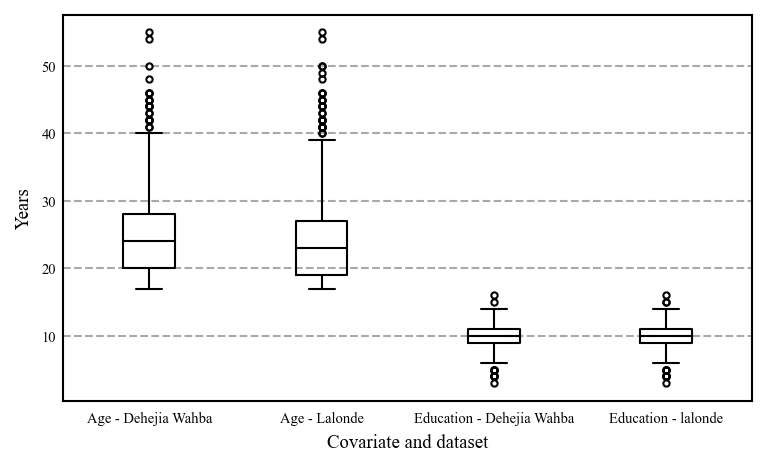

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

Age_dej = nswre74['age']
Educ_dej = nswre74['education']



ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - Dehejia Wahba', 'Age - Lalonde','Education - Dehejia Wahba','Education - lalonde'])


ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('Years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix3_wage_boxplots_cps_psid.png'

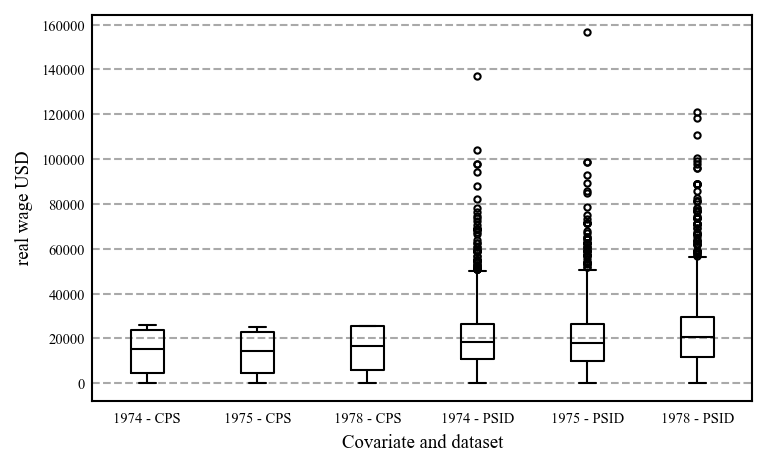

In [44]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps['re74']
wage75_cps = cps['re75']
wage78_cps = cps['re78']

wage74_psid = psid['re74']
wage75_psid = psid['re75']
wage78_psid = psid['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['1974 - CPS', '1975 - CPS','1978 - CPS','1974 - PSID','1975 - PSID','1978 - PSID'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix3_wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


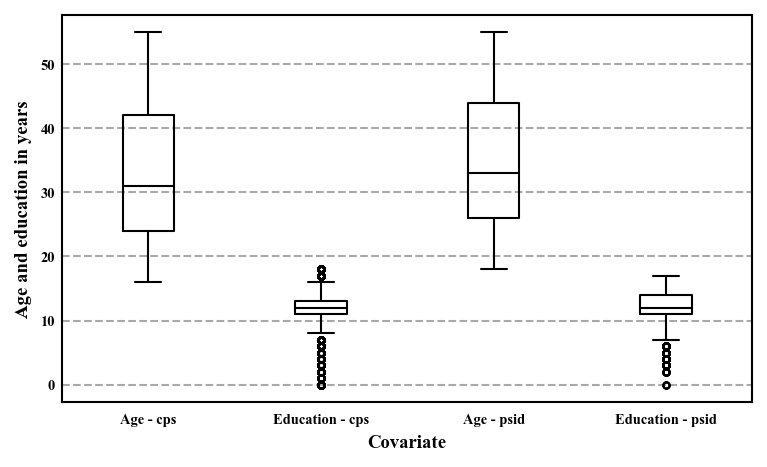

In [ ]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps['age']
Educ_cps = cps['education']

Age_psid = psid['age']
Educ_psid = psid['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - cps', 'Education - cps','Age - psid','Education - psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix4_age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [45]:
# Drop outliers 
#cols = ['re75','re78','age','education'] 
#cols2 = ['re74','re75','re78','age','education'] 

#lower_bound = 0.5
#upper_bound = 0.95

#Q1_1 = nsw[cols].quantile(lower_bound)
#Q3_1 = nsw[cols].quantile(upper_bound)
#IQR_1 = Q3_1 - Q1_1

#Q1_2 = nswre74[cols2].quantile(lower_bound)
#Q3_2 = nswre74[cols2].quantile(upper_bound)
#IQR_2 = Q3_2 - Q1_2

#Q1_3 = cps[cols2].quantile(lower_bound)
#Q3_3 = cps[cols2].quantile(upper_bound)
#IQR_3 = Q3_3 - Q1_3

#Q1_4 = psid[cols2].quantile(lower_bound)
#Q3_4 = psid[cols2].quantile(upper_bound)
#IQR_4 = Q3_4 - Q1_4

#nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

#nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

#cps = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
#psid = psid[~((psid[cols2] < (Q1_4 - IQR_4)) |(psid[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (0 mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

In [46]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer

    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 

    warnings.filterwarnings('ignore')

    if 're74' in dataset.columns: 
        dataset['re74'] = dataset['re74'].astype(int)  
        warnings.filterwarnings('ignore')
    else:
        pass

    # Keep a copy of education as numerical 
    dataset['education*'] = dataset['education']

    # Generate dummy variables 
    dataset['u75'] = (dataset['re75'] == 0).astype(int)
    # Generate interaction terms 
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    dataset['married_u75'] = dataset['married']*dataset['u75'] # married * unemployed 1975
    dataset['married_u75'] = dataset['married']*dataset['u75'] # married * wage 1975
    dataset['nodegree_re75'] = dataset['nodegree']*dataset['re75']# nodegree * wage 1975
    dataset['nodegree_u75'] = dataset['nodegree']*dataset['u75']# nodegree * unemployed 1975
    dataset['nodegree_education'] = dataset['nodegree']*dataset['education']
    dataset['black_age'] = dataset['black']*dataset['age']
    dataset['black_education'] = dataset['black']*dataset['education']
    dataset['hisp_re75'] = dataset['hispanic']*dataset['u75']
    
    if 're74' in dataset.columns: 
        dataset['u74'] = (dataset['re74'] == 0).astype(int)
        dataset['educ_re74'] = dataset['education']*dataset['re74']
        dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
        dataset['black_u74'] = dataset['black']*dataset['u74']
        dataset['married_u74'] = dataset['married']*dataset['u74']
        dataset['married_re74'] = dataset['married']*dataset['re74']
        dataset['nodegree_u75'] = dataset['nodegree']*dataset['u74']
        dataset['nodegree_u74'] = dataset['nodegree']*dataset['u74']
        dataset['nodegree_re74'] = dataset['nodegree']*dataset['re74']
        dataset['nodegree_re75'] = dataset['nodegree']*dataset['re75']
    else:
        pass    

    # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 0] = 1
    dataset['re75'][dataset['re75'] == 0] = 1

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 0] = 1
    else:
        pass     
        
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    dataset['re78sq'] = dataset['re78']*dataset['re78']
    dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['educsq'] = dataset['education']*dataset['education']

    if 're74' in dataset.columns:
        dataset['re74sq'] = dataset['re74']*dataset['re74']
    else:
        pass      

    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    else:
        pass     
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['lnre74'] = np.log(dataset['re74'])
    else:
        pass 

        # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 1] = 0
    dataset['re75'][dataset['re75'] == 1] = 0

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 1] = 0
    else:
        pass    

    # encode education as binary indicator variable 
    dataset = pd.get_dummies(dataset, columns=["education"],drop_first=True)
    
    return dataset  

In [47]:
# Combine lalonde treated units with cps and psid groups

# Create quasi-experimental datasets 
cps_no_re74 = cps.drop(['re74'],axis=1)   # drop wage in 1974 from cps comparison for merging with lalondes data 
psid_no_re74 = psid.drop(['re74'],axis=1) # drop wage in 1974 from psid comparison for merging with lalondes data 

Quasi_NswCps_lalonde_ = pd.concat([nsw[nsw['treat']==1],cps_no_re74],ignore_index=True)
Quasi_NswPsid_lalonde_ = pd.concat([nsw[nsw['treat']==1],psid_no_re74],ignore_index=True)

Quasi_NswCps_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],cps],ignore_index=True)
Quasi_NswPsid_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],psid], ignore_index=True)



# Pass data sets through feature transformation function 
nsw_transformed = feature_tranform(nsw)
nswre74_transformed = feature_tranform(nswre74)
Quasi_NswCps_lalonde = feature_tranform(Quasi_NswCps_lalonde_)
Quasi_NswPsid_lalonde = feature_tranform(Quasi_NswPsid_lalonde_)
Quasi_NswCps_dehWab = feature_tranform(Quasi_NswCps_dehWab_)
Quasi_NswPsid_dehWab = feature_tranform(Quasi_NswPsid_dehWab_)

In [48]:
nsw_transformed.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,...,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,0.411357,24.520776,0.800554,0.105263,0.162050,0.779778,3042.592798,5454.259003,10.267313,0.400277,...,0.020776,0.085873,0.152355,0.224377,0.270083,0.168975,0.031856,0.015235,0.002770,0.001385
std,0.492421,6.625947,0.399861,0.307105,0.368752,0.414683,5066.021008,6252.821190,1.704774,0.490294,...,0.142731,0.280370,0.359613,0.417460,0.444310,0.374990,0.175738,0.122573,0.052595,0.037216
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,23.000000,1.000000,0.000000,0.000000,1.000000,936.000000,3951.500000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,27.000000,1.000000,0.000000,0.000000,1.000000,3993.000000,8771.500000,11.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,37431.000000,60307.000000,16.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
nswre74_transformed.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_7,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16
count,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,...,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000
mean,0.415730,25.370787,0.833708,0.08764,0.168539,0.782022,2102.128090,1376.955056,5300.404494,10.195506,...,0.020225,0.08764,0.152809,0.229213,0.256180,0.168539,0.029213,0.01573,0.002247,0.002247
std,0.493402,7.100282,0.372762,0.28309,0.374766,0.413337,5363.417594,3150.807175,6631.361546,1.792119,...,0.140927,0.28309,0.360208,0.420800,0.437014,0.374766,0.168594,0.12457,0.047405,0.047405
min,0.000000,17.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,20.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,24.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.000000,10.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,28.000000,1.000000,0.00000,0.000000,1.000000,824.000000,1220.000000,8124.000000,11.000000,...,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.00000,1.000000,1.000000,39570.000000,25142.000000,60307.000000,16.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [50]:
Quasi_NswCps_lalonde.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
count,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,...,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000,16289.000000
mean,0.018233,33.068451,0.086807,0.072442,0.701823,0.303763,13457.362637,14684.453803,11.997483,0.114126,...,0.053103,0.072564,0.069740,0.387562,0.066794,0.071398,0.029161,0.083983,0.020443,0.036896
std,0.133810,11.041216,0.281553,0.259226,0.457465,0.459920,9317.138328,9677.387330,2.863578,0.317974,...,0.224246,0.259428,0.254717,0.487209,0.249672,0.257496,0.168262,0.277371,0.141515,0.188512
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,4017.000000,5367.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,14284.000000,16136.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,42.000000,0.000000,0.000000,1.000000,1.000000,22783.000000,25564.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,37431.000000,60307.000000,18.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
Quasi_NswPsid_lalonde.describe()

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
count,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,...,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000,2787.000000
mean,0.106566,33.761033,0.309293,0.039110,0.791891,0.350556,17358.130965,19893.421600,11.931826,0.129171,...,0.062433,0.053104,0.078938,0.085755,0.327951,0.052386,0.067815,0.023681,0.101902,0.075709
std,0.308610,10.587496,0.462286,0.193889,0.406025,0.477230,13858.764660,15632.545188,3.021046,0.335449,...,0.241983,0.224280,0.269690,0.280053,0.469551,0.222844,0.251473,0.152082,0.302573,0.264579
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,1.000000,0.000000,6795.500000,8629.500000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,16112.000000,19210.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,43.000000,1.000000,0.000000,1.000000,1.000000,25064.000000,28076.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,156653.000000,121173.000000,17.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
Quasi_NswCps_dehWab.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
count,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,...,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000,16177.000000
mean,0.011436,33.140508,0.082339,0.071892,0.705755,0.300550,13880.070100,13511.766026,14749.009705,12.008283,...,0.052482,0.071459,0.068183,0.388885,0.067071,0.071892,0.029301,0.084565,0.020585,0.037152
std,0.106329,11.036508,0.274889,0.258317,0.455717,0.458511,9613.066198,9313.110724,9670.841435,2.868005,...,0.223004,0.257599,0.252068,0.487512,0.250152,0.258317,0.168654,0.278241,0.141994,0.189139
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,4075.000000,4103.000000,5492.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,14892.000000,14374.000000,16240.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,42.000000,0.000000,0.000000,1.000000,1.000000,23491.000000,22830.000000,25564.000000,13.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,35040.000000,25243.000000,60307.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
Quasi_NswPsid_dehWab.describe()

,treat,age,black,hispanic,married,nodegree,re74,re75,re78,education*,...,education_8,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17
count,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,...,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000
mean,0.069159,34.225794,0.291589,0.034393,0.819439,0.333084,18229.575701,17850.456075,20501.917009,11.994393,...,0.062056,0.049346,0.072523,0.077009,0.333458,0.053458,0.070654,0.024299,0.106168,0.078879
std,0.253772,10.499842,0.454579,0.182269,0.384726,0.471404,13722.175528,13877.698078,15632.435118,3.053556,...,0.241302,0.216629,0.259401,0.266656,0.471537,0.224987,0.256294,0.154005,0.308110,0.269599
min,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,1.000000,0.000000,8816.000000,7604.500000,9243.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,32.000000,0.000000,0.000000,1.000000,0.000000,17437.000000,17008.000000,19432.000000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,43.500000,1.000000,0.000000,1.000000,1.000000,25470.000000,25583.000000,28815.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,137148.000000,156653.000000,121173.000000,17.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
pd.set_option('display.min_rows', 200)

### Save datasets

In [55]:
nsw_transformed.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv',header = True,index = False)
nswre74_transformed.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv',header = True,index = False)
Quasi_NswCps_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)
Quasi_NswCps_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv',header = True,index = False)
Quasi_NswPsid_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv',header = True,index = False)

# Class imbalance plots for QuasiExperimental datasets 

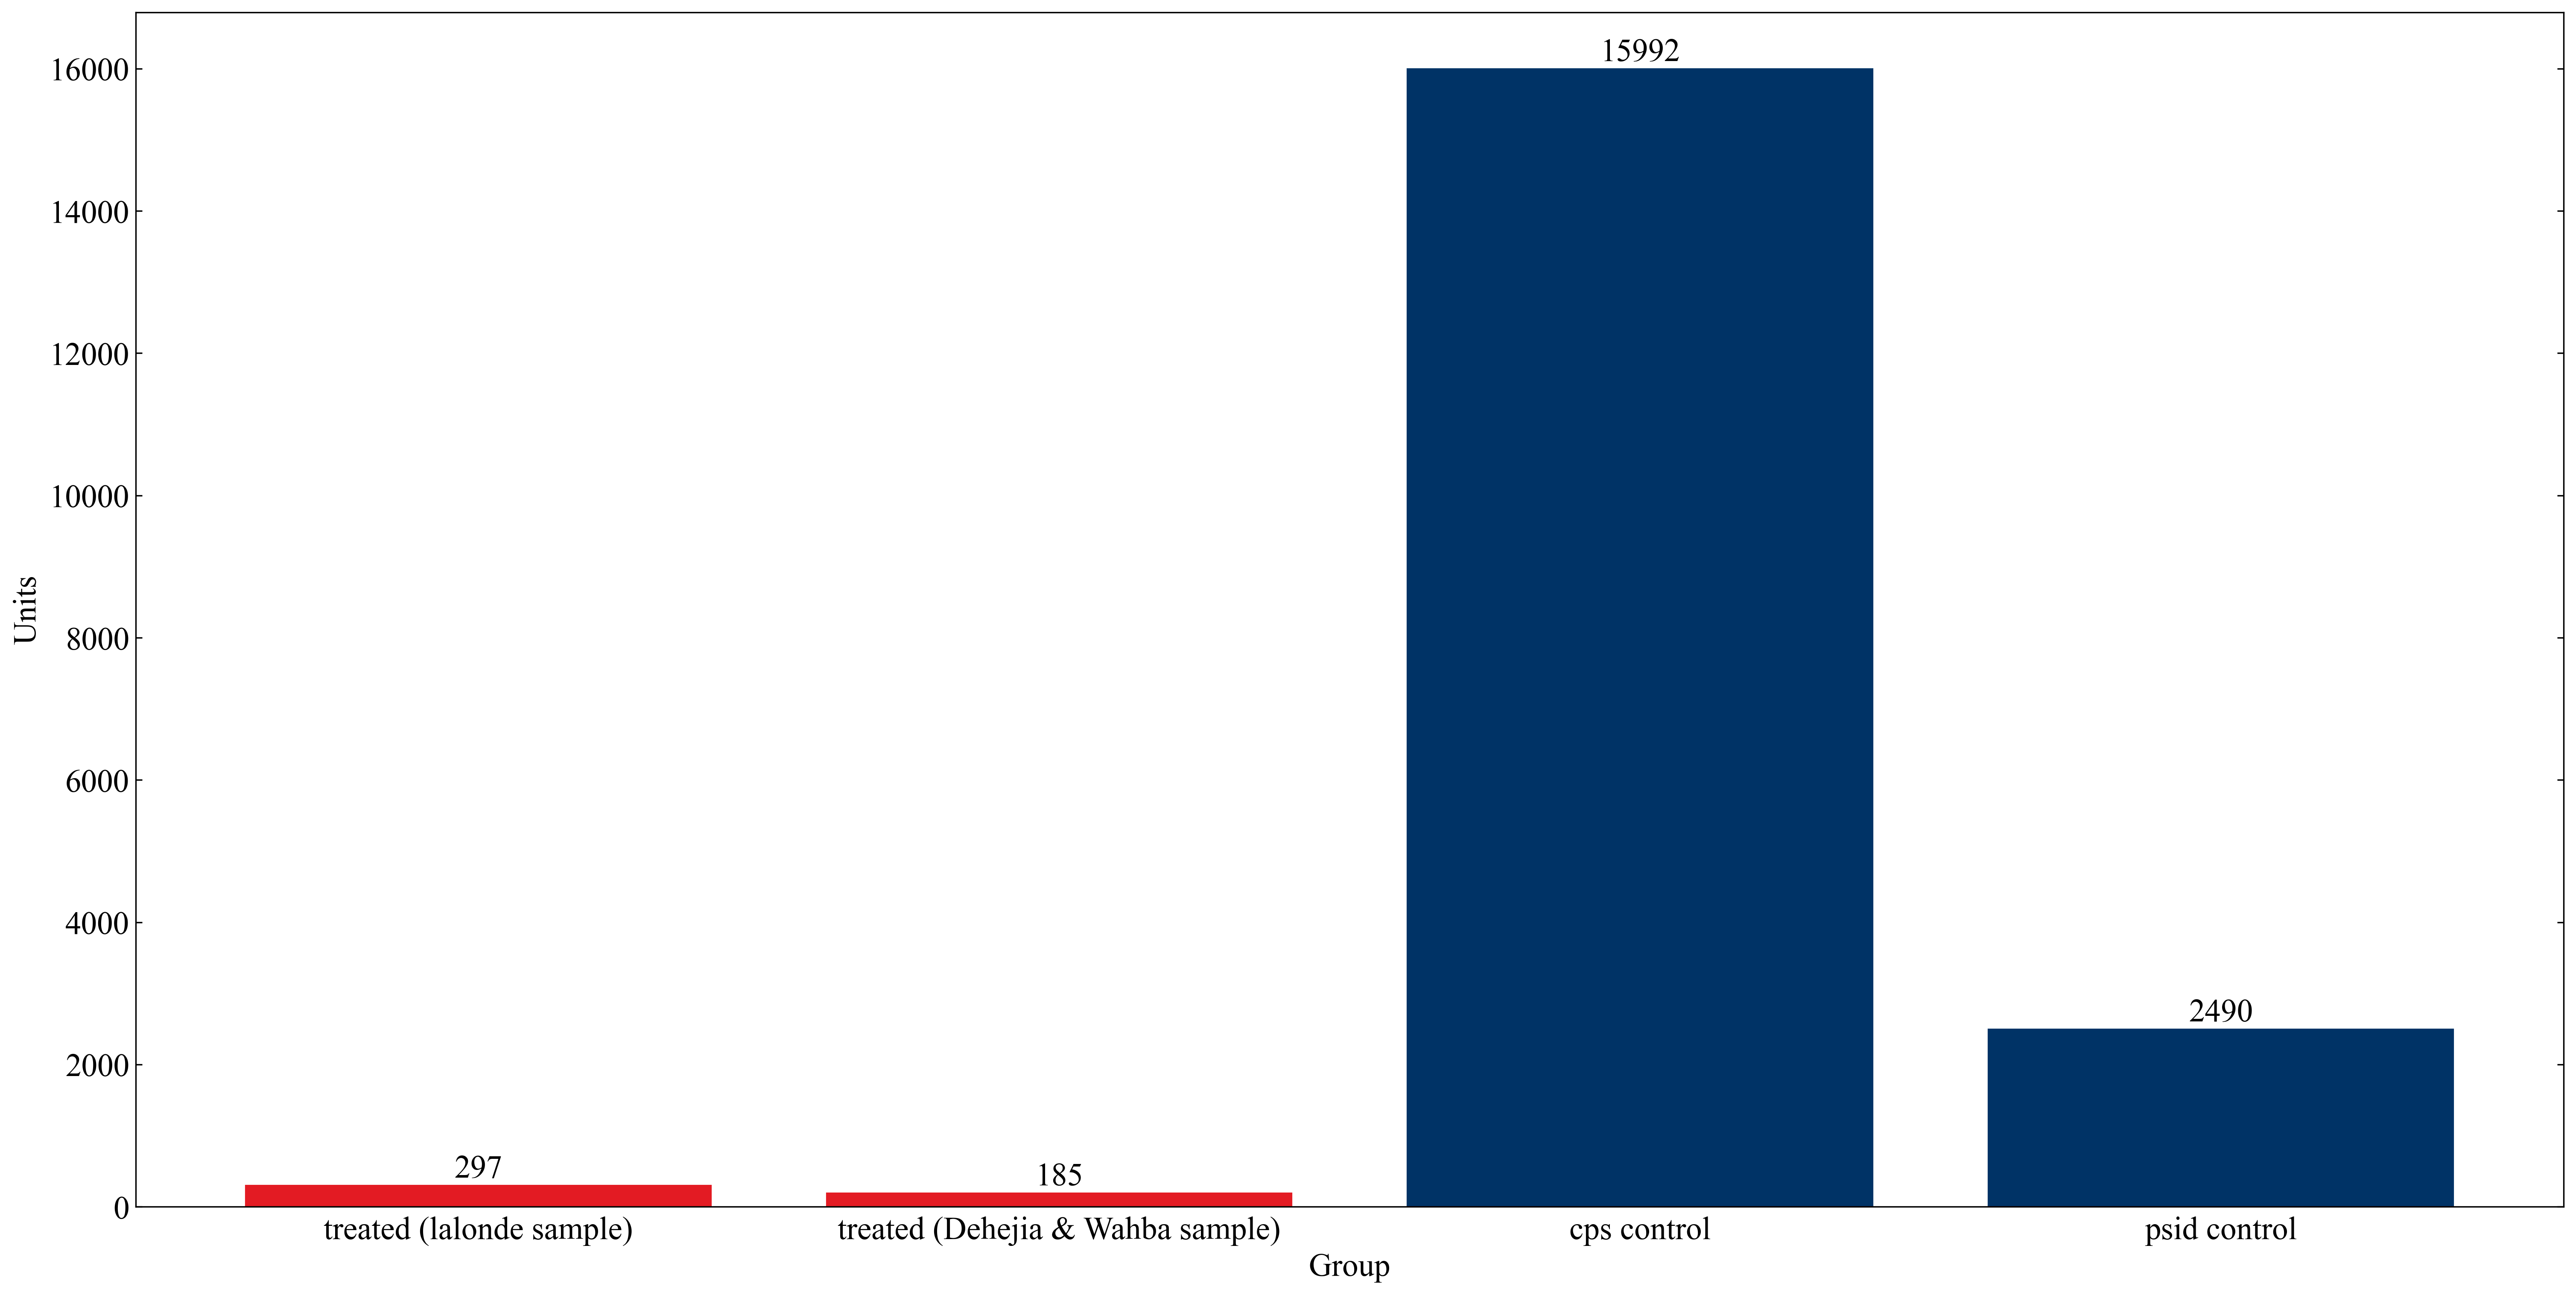

In [58]:
# Plot the balance of classes in the datasets 

# Lalonde sample 
lalondeTreated = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==1] # Treated lalonde 
dehWabTreated = Quasi_NswCps_dehWab[Quasi_NswCps_dehWab['treat']==1] # Treated dehWab


cpsControl = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==0] # Cps control
psidControl = Quasi_NswPsid_lalonde[Quasi_NswPsid_lalonde['treat']==0] # Psid control

nsw_heights = [len(lalondeTreated),len(dehWabTreated),len(cpsControl),len(psidControl)]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (20,10))


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax.set_facecolor('white')
ax.grid(color='white', axis='y')
ax.grid(color='white', axis='x')
#ax[0].set_ylim(0,700)

ax.spines['left']
ax.spines['bottom']
ax.spines['top']

ax.tick_params(right='on')
ax.tick_params(left='on')
#ax.tick_params(top='on')

ax.set_xlabel("Group")
ax.set_ylabel("Units")

bar = ax.bar(['treated (lalonde sample)','treated (Dehejia & Wahba sample)','cps control','psid control'],nsw_heights,width = 0.8)
# colour chart 
bar[0].set_color('#E31B23')
bar[1].set_color('#E31B23')
bar[2].set_color('#003366')
bar[3].set_color('#003366')

# Add counts to bar chart - lalonde sample 
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/lalonde_notebook_plots/fig1_Quasi_data_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()

### Smote illustration

In [62]:
Quasi_NswCps_lalonde

,treat,age,black,hispanic,married,nodegree,re75,re78,education*,u75,...,education_9,education_10,education_11,education_12,education_13,education_14,education_15,education_16,education_17,education_18
0,1.0,37,1.0,0.0,1.0,1.0,0,9930,11,1,...,0,0,1,0,0,0,0,0,0,0
1,1.0,22,0.0,1.0,0.0,1.0,0,3595,9,1,...,1,0,0,0,0,0,0,0,0,0
2,1.0,30,1.0,0.0,0.0,0.0,0,24909,12,1,...,0,0,0,1,0,0,0,0,0,0
3,1.0,27,1.0,0.0,0.0,1.0,0,7506,11,1,...,0,0,1,0,0,0,0,0,0,0
4,1.0,33,1.0,0.0,0.0,1.0,0,289,8,1,...,0,0,0,0,0,0,0,0,0,0
5,1.0,22,1.0,0.0,0.0,1.0,0,4056,9,1,...,1,0,0,0,0,0,0,0,0,0
6,1.0,23,1.0,0.0,0.0,0.0,0,0,12,1,...,0,0,0,1,0,0,0,0,0,0
7,1.0,32,1.0,0.0,0.0,1.0,0,8472,11,1,...,0,0,1,0,0,0,0,0,0,0
8,1.0,22,1.0,0.0,0.0,0.0,0,2164,16,1,...,0,0,0,0,0,0,0,1,0,0
9,1.0,33,0.0,0.0,1.0,0.0,0,12418,12,1,...,0,0,0,1,0,0,0,0,0,0


In [61]:
resample_demo =SMOTEENN(random_state=0)

#resample data
features, target = resample_demo.fit_resample(Quasi_NswCps_lalonde.drop('treat', axis=1), Quasi_NswCps_lalonde['treat'])	
Quasi_NswCps_lalonde_smote = pd.concat([features,target],axis=1)

color= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde['treat']]
color2= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde_smote['treat']]


# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (20,8))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})

ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']
ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].set_ylim(-500,26000)


ax[0].scatter(Quasi_NswCps_lalonde['age'], Quasi_NswCps_lalonde['re78'],color=color,facecolors='white',s=35)

#ax[0].set_yticks(fontsize=18)
#ax[0].set_xticks(fontsize=18)
ax[0].tick_params(axis="x", labelsize=20)
ax[0].tick_params(axis="y", labelsize=20)

ax[0].set_xlabel('age', fontsize=20)
ax[0].set_ylabel('1978 wage', fontsize=20)
ax[0].set_title("Before smote-enn augmentation",fontsize=20)



ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']
ax[1].set_ylim(-500,26000)

ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].scatter(Quasi_NswCps_lalonde_smote['age'], Quasi_NswCps_lalonde_smote['re78'],color=color2, facecolors='white',s=35)
ax[1].tick_params(axis="x", labelsize=20)
ax[1].tick_params(axis="y", labelsize=20)
ax[1].set_xlabel('age', fontsize=20)
ax[1].set_ylabel('1978 wage', fontsize=18)
ax[1].set_title("After smote-enn augmentation",fontsize=20)

labels = ['treated','control']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/plots/lalonde_notebook_plots/fig2_SMOTE-ENN_transform_chart.png', bbox_inches='tight')

plt.show()


AttributeError: 'NoneType' object has no attribute 'split'

# 2. Propensity score estimation

In [63]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [64]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [65]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### model (1) Logistic Regression 

### Data

# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #
ps_specification_mine = ['treat','age','agesq','education*','black','hispanic','married','nodegree']

ps_specification_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']


nswCps_lalonde_subset = nswCps_lalonde[ps_specification_mine]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_mine]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

In [69]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #
ps_specification_mine = ['treat','age','agesq','education*','black','hispanic','married','nodegree']
ps_specification_mine2 = ['treat','age','agesq','education*','black','hispanic','married','nodegree']

ps_specification_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']


nswCps_lalonde_subset = nswCps_lalonde[ps_specification_mine]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_mine]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_mine2]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_mine2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [70]:
"""
We use KFold cross validation to establish performance metrics for each of our models.
Note these hyper-parameter settig may be biased 

"""

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [71]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [72]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [73]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [74]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.905441,0.876642,0.888127,0.921088,0.917321,0.901724
Precision:,0.159292,0.163399,0.153153,0.160350,0.149864,0.157211
Recall:,0.900000,0.833333,0.864407,0.932203,0.932203,0.892429
MSE:,0.089319,0.081645,0.089012,0.089626,0.097022,0.089325
MAE:,0.089319,0.081645,0.089012,0.089626,0.097022,0.089325
R^2:,-3.940994,-3.516510,-4.005908,-4.040431,-4.454744,-3.991717
auc:,0.905441,0.876642,0.888127,0.921088,0.917321,0.901724
roc_auc:,0.964926,0.947819,0.940384,0.961471,0.971847,0.957289
F1:,0.270677,0.273224,0.260204,0.273632,0.258216,0.267191
log-loss:,0.253979,0.232360,0.250807,0.262241,0.275007,0.254879


In [75]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [76]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.865763,0.922189,0.837622,0.888027,0.917347,0.886190
Precision:,0.463636,0.604396,0.469388,0.536842,0.495575,0.513967
Recall:,0.850000,0.916667,0.779661,0.864407,0.949153,0.871977
MSE:,0.121864,0.073477,0.116697,0.093357,0.107720,0.102623
MAE:,0.121864,0.073477,0.116697,0.093357,0.107720,0.102623
R^2:,-0.269880,0.234337,-0.232217,0.014226,-0.137431,-0.078193
auc:,0.865763,0.922189,0.837622,0.888027,0.917347,0.886190
roc_auc:,0.943876,0.959990,0.927081,0.963124,0.954581,0.949730
F1:,0.600000,0.728477,0.585987,0.662338,0.651163,0.645593
log-loss:,0.306646,0.252428,0.291314,0.248859,0.355282,0.290906


In [77]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [78]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.881720,0.887731,0.882490,0.923411,0.942865,0.903643
Precision:,0.115242,0.100629,0.117424,0.099432,0.114286,0.109402
Recall:,0.837838,0.864865,0.837838,0.945946,0.972973,0.891892
MSE:,0.075402,0.089926,0.073879,0.098609,0.086553,0.084874
MAE:,0.075402,0.089926,0.073879,0.098609,0.086553,0.084874
R^2:,-5.670868,-6.955831,-5.534194,-7.721371,-6.655122,-6.507477
auc:,0.881720,0.887731,0.882490,0.923411,0.942865,0.903643
roc_auc:,0.942647,0.942393,0.962612,0.971190,0.978331,0.959435
F1:,0.202614,0.180282,0.205980,0.179949,0.204545,0.194674
log-loss:,0.226007,0.271259,0.218627,0.270706,0.256733,0.248666


In [79]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [80]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.862694,0.872734,0.891729,0.883697,0.913736,0.884918
Precision:,0.356322,0.402597,0.379310,0.347368,0.372340,0.371588
Recall:,0.837838,0.837838,0.891892,0.891892,0.945946,0.881081
MSE:,0.115888,0.097196,0.108411,0.123364,0.114019,0.111776
MAE:,0.115888,0.097196,0.108411,0.123364,0.114019,0.111776
R^2:,-0.800174,-0.509823,-0.684033,-0.916314,-0.771139,-0.736297
auc:,0.862694,0.872734,0.891729,0.883697,0.913736,0.884918
roc_auc:,0.939922,0.936883,0.952024,0.941496,0.960572,0.946179
F1:,0.500000,0.543860,0.532258,0.500000,0.534351,0.522094
log-loss:,0.284339,0.285811,0.304736,0.356966,0.309083,0.308187


In [81]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [82]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [83]:
# Change logisistic regression to STAT's model implementation 

In [84]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [85]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT = propensity_score_funct(nswCps_lalonde_subset,logit1)
nswPsid_lalonde_ps_LOGIT = propensity_score_funct(nswPsid_lalonde_subset,logit2)

# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT,nswCps_lalonde_re78,left_index=True, right_index=True)
#nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT_withRe78,nswCps_lalonde['nodegree'],left_index=True, right_index=True)
nswPsid_lalonde_ps_LOGIT_withRe78 = pd.merge(nswPsid_lalonde_ps_LOGIT,nswPsid_lalonde_re78,left_index=True, right_index=True)
#nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT_withRe78,nswPsid_lalonde['nodegree'],left_index=True, right_index=True)


# ============ Dehejia & Wahba sub sample ============ # 
nswCps_dehWab_ps_LOGIT = propensity_score_funct(nswCps_dehWab_subset,logit3)
nswPsid_dehWab_ps_LOGI = propensity_score_funct(nswPsid_dehWab_subset,logit4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_LOGIT_withRe78 = pd.merge(nswCps_dehWab_ps_LOGIT,nswCps_dehWab_re78,left_index=True, right_index=True)
#nswCps_dehWab_ps_LOGIT_withRe78 = pd.merge(nswCps_dehWab_ps_LOGIT_withRe78,nswCps_dehWab['nodegree'],left_index=True, right_index=True)
nswPsid_dehWab_ps_LOGIT_withRe78  = pd.merge(nswPsid_dehWab_ps_LOGI,nswPsid_dehWab_re78,left_index=True, right_index=True)
#nswPsid_dehWab_ps_LOGIT_withRe78  = pd.merge(nswPsid_dehWab_ps_LOGIT_withRe78,nswPsid_dehWab['nodegree'],left_index=True, right_index=True)

In [55]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT.csv')

# new spec

In [88]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT2.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT2.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT2.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT2.csv')

### model (2) ; CART 

In [89]:
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [90]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

#### Data prep for CART

In [91]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [59]:
""" Select covariates for use in CART model """
# ======== Lalonde (1986) data ======== #
cartSpecification1 = ['treat','age','education*','black','hispanic','married','nodegree','re75'] # Lalonde sample 
cartSpecification2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75'] # Dehejia and wahba sample 

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[cartSpecification1]
nswPsid_lalonde_subset = nswPsid_lalonde[cartSpecification1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[cartSpecification2]
nswPsid_dehWab_subset = nswPsid_dehWab[cartSpecification2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


# CART - Feature selected

In [110]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #
cartSpecification_causaldisc1 = ['treat','education*','black','black_education','married','nodegree'] # Lalonde sample 
cartSpecification_causaldisc2 = ['treat','education*','black','black_education','married','nodegree'] # Dehejia and wahba sample 

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[cartSpecification_causaldisc1]
nswPsid_lalonde_subset = nswPsid_lalonde[cartSpecification_causaldisc1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[cartSpecification_causaldisc2]
nswPsid_dehWab_subset = nswPsid_dehWab[cartSpecification_causaldisc2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [111]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [112]:
# dataframes to store resutls 
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()
#models 
grid_search_cart1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart3 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart4 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)


In [62]:
# Takes appx 65 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 

In [63]:
grid_search_cart1.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 2}

In [64]:
grid_search_cart2.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 2}

In [65]:
grid_search_cart3.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_leaf_nodes': 34,
 'min_samples_leaf': 2}

In [66]:
grid_search_cart4.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 21,
 'min_samples_leaf': 3}

<p> To run each cart model using pre-established best parameters from grid search (to save time of running models) </p>

In [113]:
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()

grid_search_cart1 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 12,min_samples_leaf = 2)
grid_search_cart2 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 7,max_leaf_nodes = 20,min_samples_leaf = 2)
grid_search_cart3 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart4 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)

In [114]:
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [115]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [116]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.847358,0.840916,0.846136,0.862738,0.740150,0.827460
Precision:,0.111617,0.068238,0.110092,0.127273,0.034282,0.090300
Recall:,0.816667,0.916667,0.813559,0.830508,1.000000,0.875480
MSE:,0.123082,0.232044,0.122468,0.106200,0.510286,0.218816
MAE:,0.123082,0.232044,0.122468,0.106200,0.510286,0.218816
R^2:,-5.808724,-11.836398,-5.887438,-4.972566,-27.689191,-11.238863
auc:,0.847358,0.840916,0.846136,0.862738,0.740150,0.827460
roc_auc:,0.767112,0.825678,0.843688,0.912889,0.740775,0.818028
F1:,0.196393,0.127021,0.193939,0.220721,0.066292,0.160873
log-loss:,3.139832,7.652616,3.944355,3.555940,17.593053,7.177159


In [117]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.708133,0.790964,0.869393,0.904857,0.754135,0.805496
Precision:,0.191011,0.333333,0.422764,0.474138,0.200000,0.324249
Recall:,0.850000,0.766667,0.881356,0.932203,0.966102,0.879266
MSE:,0.403226,0.189964,0.140036,0.116697,0.412926,0.252570
MAE:,0.403226,0.189964,0.140036,0.116697,0.412926,0.252570
R^2:,-3.201807,-0.979518,-0.478660,-0.232217,-3.360152,-1.650471
auc:,0.708133,0.790964,0.869393,0.904857,0.754135,0.805496
roc_auc:,0.704769,0.808199,0.877068,0.904516,0.754101,0.809731
F1:,0.311927,0.464646,0.571429,0.628571,0.331395,0.461594
log-loss:,13.867979,6.389181,4.721608,4.036780,14.263217,8.655753


In [118]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.861883,0.846950,0.864979,0.860221,0.773000,0.841406
Precision:,0.131222,0.074257,0.082447,0.094044,0.039886,0.084371
Recall:,0.783784,0.810811,0.837838,0.810811,0.756757,0.800000
MSE:,0.061805,0.117738,0.108501,0.091499,0.211128,0.118134
MAE:,0.061805,0.117738,0.108501,0.091499,0.211128,0.118134
R^2:,-4.467925,-9.416397,-8.596243,-7.092558,-17.673030,-9.449231
auc:,0.861883,0.846950,0.864979,0.860221,0.773000,0.841406
roc_auc:,0.880461,0.824472,0.879464,0.827739,0.708268,0.824081
F1:,0.224806,0.136054,0.150121,0.168539,0.075778,0.151060
log-loss:,1.299302,2.123406,1.990872,2.316933,6.536740,2.853451


In [119]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.844540,0.846711,0.845083,0.824541,0.823700,0.836915
Precision:,0.246269,0.391892,0.268908,0.248000,0.397059,0.310425
Recall:,0.891892,0.783784,0.864865,0.837838,0.729730,0.821622
MSE:,0.196262,0.099065,0.171963,0.186916,0.095327,0.149907
MAE:,0.196262,0.099065,0.171963,0.186916,0.095327,0.149907
R^2:,-2.048681,-0.538858,-1.671225,-1.903506,-0.480788,-1.328612
auc:,0.844540,0.846711,0.845083,0.824541,0.823700,0.836915
roc_auc:,0.837946,0.845626,0.862314,0.785113,0.867443,0.839688
F1:,0.385965,0.522523,0.410256,0.382716,0.514286,0.443149
log-loss:,5.583802,3.422243,5.715585,5.815709,2.986552,4.704778


### Inference

In [120]:
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0)
    dataset_proba['propensity_logit'].replace(-np.Inf,0)
    dataset_proba['propensity_logit'].replace(np.Inf,0)
    return dataset_proba
    

In [121]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_CART = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1)
nswPsid_lalonde_ps_CART = propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_CART_withRe78 = pd.merge(nswCps_lalonde_ps_CART,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_CART_withRe78 = pd.merge(nswPsid_lalonde_ps_CART,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3)
nswPsid_dehWab_ps_CART = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_CART_withRe78 = pd.merge(nswCps_dehWab_ps_CART,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_CART_withRe78  = pd.merge(nswPsid_dehWab_ps_CART,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [132]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART.csv')

# Feature selected PS estimates

In [122]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART2.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART2.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART2.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART2.csv')

In [133]:
# Load matched data from STATA
#nswCps_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_lalonde_CART_psMatched.csv',header = True,index = False)
#nswPsid_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_lalonde_CART_psMatched.csv',header = True,index = False)
#nswCps_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_dehWab_CART_psMatched.csv',header = True,index = False)
#nswPsid_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_dehWab_CART_psMatched.csv',header = True,index = False)

### model (3) ; Random Forest

In [109]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [123]:
""" DW and Lalonde spec covariates for use in FOREST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
forest_specification1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']
forest_specification2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[forest_specification1]
nswPsid_lalonde_subset = nswPsid_lalonde[forest_specification1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[forest_specification2]
nswPsid_dehWab_subset = nswPsid_dehWab[forest_specification2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


# Feature selected

In [124]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
forestSpecification_causaldisc1 = ['treat','education*','black','black_education','married','nodegree'] # Lalonde sample 
forestSpecification_causaldisc2 = ['treat','education*','black','black_education','married','nodegree'] # Dehejia and wahba sample 

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[forestSpecification_causaldisc1]
nswPsid_lalonde_subset = nswPsid_lalonde[forestSpecification_causaldisc1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[forestSpecification_causaldisc2]
nswPsid_dehWab_subset = nswPsid_dehWab[forestSpecification_causaldisc2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [125]:
from sklearn.ensemble import RandomForestClassifier   
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [126]:
# Grid search 
forest_param_grid = { 
    'n_estimators': [100,500,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split':[1,2,3],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [127]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
# dataframes to store resutls 
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()
#models 
grid_search_forest1 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest2 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest3 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest4 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)

In [ ]:
# Takes appx 116 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======= #
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

In [1]:
# Best parameters 
grid_search_forest1.best_params_

NameError: name 'grid_search_forest1' is not defined

In [ ]:
grid_search_forest2.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
grid_search_forest3.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_split': 3,
 'n_estimators': 500}

In [ ]:
grid_search_forest4.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

<p> To run each forest model using pre-established best parameters from grid searcg (to save time of running models) </p>

In [128]:
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()

grid_search_forest1 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest2 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest3 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'log2',min_samples_split = 3,n_estimators= 500)
grid_search_forest4 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'log2',min_samples_leaf = 2,n_estimators= 500)

In [129]:
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [130]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [131]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.704722,0.658333,0.841359,0.717605,0.735147,0.731433
Precision:,0.037008,0.029733,0.086655,0.035815,0.033657,0.044574
Recall:,0.800000,0.816667,0.847458,0.864407,1.000000,0.865706
MSE:,0.387047,0.494168,0.164518,0.423880,0.520111,0.397945
MAE:,0.387047,0.494168,0.164518,0.423880,0.520111,0.397945
R^2:,-20.410976,-26.336773,-8.252298,-22.838477,-28.241570,-21.216019
auc:,0.704722,0.658333,0.841359,0.717605,0.735147,0.731433
roc_auc:,0.709535,0.666140,0.866455,0.741749,0.753710,0.747518
F1:,0.070744,0.057377,0.157233,0.068780,0.065121,0.083851
log-loss:,13.001490,14.434917,2.441618,12.985838,15.856025,11.743978


In [132]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.699799,0.788956,0.869393,0.878191,0.737186,0.794705
Precision:,0.187970,0.328571,0.422764,0.368421,0.194346,0.300415
Recall:,0.833333,0.766667,0.881356,0.949153,0.932203,0.872542
MSE:,0.405018,0.193548,0.140036,0.177738,0.416517,0.266571
MAE:,0.405018,0.193548,0.140036,0.177738,0.416517,0.266571
R^2:,-3.220482,-1.016867,-0.478660,-0.876761,-3.398067,-1.798168
auc:,0.699799,0.788956,0.869393,0.878191,0.737186,0.794705
roc_auc:,0.817085,0.810843,0.885338,0.907001,0.864492,0.856952
F1:,0.306748,0.460000,0.571429,0.530806,0.321637,0.438124
log-loss:,6.321022,4.932165,3.727691,3.674771,7.077471,5.146624


In [133]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.848994,0.802645,0.695139,0.701705,0.619868,0.733670
Precision:,0.129630,0.048333,0.023333,0.024180,0.016939,0.048483
Recall:,0.756757,0.783784,0.756757,0.756757,0.729730,0.756757
MSE:,0.060878,0.178925,0.365070,0.352087,0.487481,0.288888
MAE:,0.060878,0.178925,0.365070,0.352087,0.487481,0.288888
R^2:,-4.385906,-14.829643,-31.288212,-30.139944,-42.114742,-24.551689
auc:,0.848994,0.802645,0.695139,0.701705,0.619868,0.733670
roc_auc:,0.878053,0.856433,0.845220,0.728741,0.606376,0.782965
F1:,0.221344,0.091052,0.045271,0.046862,0.033109,0.087527
log-loss:,0.943436,4.218805,2.840185,10.240871,14.524588,6.553577


In [134]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.742131,0.819060,0.848095,0.812032,0.822696,0.808803
Precision:,0.139831,0.258621,0.275862,0.243902,0.391304,0.261904
Recall:,0.891892,0.810811,0.864865,0.810811,0.729730,0.821622
MSE:,0.386916,0.173832,0.166355,0.186916,0.097196,0.202243
MAE:,0.386916,0.173832,0.166355,0.186916,0.097196,0.202243
R^2:,-5.010257,-1.700261,-1.584120,-1.903506,-0.509823,-2.141593
auc:,0.742131,0.819060,0.848095,0.812032,0.822696,0.808803
roc_auc:,0.890454,0.861419,0.912895,0.893629,0.906762,0.893032
F1:,0.241758,0.392157,0.418301,0.375000,0.509434,0.387330
log-loss:,3.000110,2.019562,2.453370,2.692904,0.945929,2.222375


### Inference

In [135]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_FOREST = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1)
nswPsid_lalonde_ps_FOREST = propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_FOREST_withRe78 = pd.merge(nswCps_lalonde_ps_FOREST,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_FOREST_withRe78 = pd.merge(nswPsid_lalonde_ps_FOREST,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_FOREST = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3)
nswPsid_dehWab_ps_FOREST = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_FOREST_withRe78 = pd.merge(nswCps_dehWab_ps_FOREST,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_FOREST_withRe78  = pd.merge(nswPsid_dehWab_ps_FOREST,nswPsid_dehWab_re78,left_index=True, right_index=True)

In [147]:
# save unmatched forest datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST.csv')

In [127]:
# SAVE Quasi experimental datasets with lalonde treated and matched controls 
#nswCps_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_lalonde_forest_psMatched.csv',header = True,index = False)
#nswPsid_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_lalonde_forest_psMatched.csv',header = True,index = False)
#nswCps_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_dehWab_forest_psMatched.csv',header = True,index = False)
#nswPsid_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_dehWab_forest_psMatched.csv',header = True,index = False)

for i in nswCps_lalonde_FOREST_psMatched.columns[1:len(nswCps_lalonde_FOREST_psMatched)]:
    plot_matching_distributions(
                            i,nswCps_lalonde_FOREST_psMatched,nswCps_lalonde_ps_FOREST_withRe78,
                            nswPsid_lalonde_FOREST_psMatched,nswPsid_lalonde_ps_FOREST_withRe78,
                            nswCps_dehWab_FOREST_psMatched,nswCps_dehWab_ps_FOREST_withRe78,
                            nswPsid_dehWab_FOREST_psMatched,nswPsid_dehWab_ps_FOREST_withRe78,'FOREST/'f'{i}''_FOREST'
                            )


### model (4) ; Boosted Trees

In [138]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [149]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



In [150]:
from xgboost import XGBClassifier

## Validation 

<p> grid search can be skipped </p>

In [15]:
# Boosting parameters 
""""
Booster = type of model to run at each iteration
subsample = fraction of training samples (randomly selected) used to train each tree
colsample_bytree = fraction of features (randomly selected) used to train each tree

min_child_weight [default = 1] : Used to control over-fitting. 
                                Higher values prevent a model from learning 
                                relations which might be highly specific to the 
                                particular sample selected for a tree.

max_depth = max tree depth 
"""
v = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,3,4,5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
        'learning_rate': [0.01,0.025,0.05,0.075,0.1,0.2,0.3]
        }

params2 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.5, 0.7,0.8],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,None],
        'learning_rate': [0.01,0.025,0.05]
        } 

params3 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5,1],
        'subsample': [0.3,0.5],         
        'colsample_bytree': [0.3], 
        'max_depth': [1,2,3,None],
        'learning_rate': [0.01,0.05]
        }        
                       
        
# Set up tree classifier
estimator = XGBClassifier(objective= 'binary:logistic',seed=0,nthread=4)       

estimator = XGBClassifier(objective= 'binary:logistic',seed=0,nthread=4)       


In [22]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
#models 
grid_search_boost1 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost2 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost3 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost4 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')


In [279]:
# Takes appx 73 minutes
# XGboost K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 3

<p> To run each Boost model using pre-established best parameters from grid searcg (save time when running models) </p>

In [151]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()

# models 
grid_search_boost1 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost2 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost3 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 1,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost4 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 

In [152]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [153]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [154]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.862226,0.845982,0.827451,0.827330,0.919603,0.856518
Precision:,0.254144,0.352459,0.242604,0.186667,0.219008,0.250976
Recall:,0.766667,0.716667,0.694915,0.711864,0.898305,0.757684
MSE:,0.045734,0.029466,0.044813,0.061387,0.059871,0.048254
MAE:,0.045734,0.029466,0.044813,0.061387,0.059871,0.048254
R^2:,-1.529925,-0.630019,-1.520216,-2.452350,-2.366060,-1.699714
auc:,0.862226,0.845982,0.827451,0.827330,0.919603,0.856518
roc_auc:,0.955834,0.949909,0.951219,0.958454,0.980033,0.959090
F1:,0.381743,0.472527,0.359649,0.295775,0.352159,0.372371
log-loss:,0.127777,0.113366,0.128050,0.150611,0.152962,0.134553


In [155]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.863554,0.891265,0.867181,0.907103,0.929957,0.891812
Precision:,0.626667,0.742424,0.602564,0.671053,0.604396,0.649421
Recall:,0.783333,0.816667,0.796610,0.864407,0.932203,0.838644
MSE:,0.073477,0.050179,0.077199,0.059246,0.071813,0.066383
MAE:,0.073477,0.050179,0.077199,0.059246,0.071813,0.066383
R^2:,0.234337,0.477108,0.184841,0.374413,0.241713,0.302482
auc:,0.863554,0.891265,0.867181,0.907103,0.929957,0.891812
roc_auc:,0.956677,0.967102,0.953032,0.973215,0.976210,0.965247
F1:,0.696296,0.777778,0.686131,0.755556,0.733333,0.729819
log-loss:,0.185442,0.149284,0.208083,0.152082,0.193424,0.177663


In [156]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.893527,0.888994,0.892741,0.901095,0.920550,0.899381
Precision:,0.283019,0.222222,0.270270,0.213793,0.296296,0.257120
Recall:,0.810811,0.810811,0.810811,0.837838,0.864865,0.827027
MSE:,0.025649,0.034611,0.027202,0.037094,0.025039,0.029919
MAE:,0.025649,0.034611,0.027202,0.037094,0.025039,0.029919
R^2:,-1.269189,-2.062038,-1.405896,-2.280767,-1.214518,-1.646481
auc:,0.893527,0.888994,0.892741,0.901095,0.920550,0.899381
roc_auc:,0.978507,0.954580,0.978483,0.960955,0.984915,0.971488
F1:,0.419580,0.348837,0.405405,0.340659,0.441379,0.391172
log-loss:,0.095864,0.103251,0.091482,0.105370,0.091240,0.097441


In [157]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.928878,0.915364,0.922854,0.903316,0.973434,0.928769
Precision:,0.660000,0.653061,0.589286,0.524590,0.734694,0.632326
Recall:,0.891892,0.864865,0.891892,0.864865,0.972973,0.897297
MSE:,0.039252,0.041121,0.050467,0.063551,0.026168,0.044112
MAE:,0.039252,0.041121,0.050467,0.063551,0.026168,0.044112
R^2:,0.390264,0.361229,0.216053,0.012808,0.593509,0.314773
auc:,0.928878,0.915364,0.922854,0.903316,0.973434,0.928769
roc_auc:,0.983990,0.971236,0.986161,0.944236,0.989987,0.975122
F1:,0.758621,0.744186,0.709677,0.653061,0.837209,0.740551
log-loss:,0.117582,0.127595,0.131927,0.186513,0.114955,0.135714


### Inference

In [158]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_BOOST = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1)
nswPsid_lalonde_ps_BOOST = propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_BOOST_withRe78 = pd.merge(nswCps_lalonde_ps_BOOST,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_BOOST_withRe78 = pd.merge(nswPsid_lalonde_ps_BOOST,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_BOOST = propensity_score_funct(nswCps_dehWab_subset,grid_search_boost3)
nswPsid_dehWab_ps_BOOST = propensity_score_funct(nswPsid_dehWab_subset,grid_search_boost4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_BOOST_withRe78 = pd.merge(nswCps_dehWab_ps_BOOST,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_BOOST_withRe78  = pd.merge(nswPsid_dehWab_ps_BOOST,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [159]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST.csv')

for i in nswCps_lalonde_BOOST_psMatched.columns[1:len(nswCps_lalonde_BOOST_psMatched)]:
    plot_matching_distributions(
                            i,nswCps_lalonde_BOOST_psMatched,nswCps_lalonde_ps_BOOST_withRe78,
                            nswPsid_lalonde_BOOST_psMatched,nswPsid_lalonde_ps_BOOST_withRe78,
                            nswCps_dehWab_BOOST_psMatched,nswCps_dehWab_ps_BOOST_withRe78,
                            nswPsid_dehWab_BOOST_psMatched,nswPsid_dehWab_ps_BOOST_withRe78,'BOOST'f'{i}''_BOOST'
                            )

### model (5) - artifical neural network

In [6]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [7]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [8]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [9]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #

LALONDE_subset = ['treat','age','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                  'education_14', 'education_15', 'education_16', 'education_17']

LALONDE_subset2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                  'education_14', 'education_15', 'education_16', 'education_17']  

LALONDE_subset3 = ['treat','age','education*','black','hispanic','married','nodegree','lnre75']                   


nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset2]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset2]

# Z-score normalise continous variables
sc = StandardScaler()
nsw_continuos_vars = ['ageboxcox','lnre75'] 

nswCps_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars])
nswPsid_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

DW_subset = ['treat','age','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 
              'education_13', 'education_14', 'education_15', 'education_16', 'education_17']

DW_subset2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 
              'education_13', 'education_14', 'education_15', 'education_16', 'education_17']

DW_subset3 = ['treat','age','black','hispanic','married','nodegree','lnre74','lnre75','education*']

nswCps_dehWab_subset = nswCps_dehWab[DW_subset2]
nswPsid_dehWab_subset = nswPsid_dehWab[DW_subset2]

nswre74_continuos_vars = ['ageboxcox','lnre74','lnre75',] 

nswCps_dehWab_subset[nswre74_continuos_vars] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars])
nswPsid_dehWab_subset[nswre74_continuos_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_33813/2938872810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_33813/2938872810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswPsid_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000

### Inference

<p> Neural network </p>

In [13]:
# ANN model 

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = 16, num_classes=1, num_hidden_1=100, num_hidden_2=100):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X


class twoLayerNN2(nn.Module):
    def __init__(self,num_features = 17, num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       


### Model validation

In [14]:
from skorch import NeuralNetClassifier
ANN = NeuralNetClassifier(twoLayerNN1,
                          max_epochs=100,lr=0.1,
                          optimizer = optim.Adam,
                          criterion = nn.BCELoss,
                        
                          )

ANN1_params = {

    'lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'max_epochs': [100],
    'batch_size':[32,64,512],
    #'module__num_features':[17],
    'module__num_hidden_1':[5,15,100],
    'module__num_hidden_2':[5,15,100],
   'optimizer__weight_decay':[0.2,0.1,0.01,0.001]
}

ANN_params = {
    'classification__lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'classification__max_epochs': [50],
    'classification__batch_size':[64,512],
}

In [15]:

Epochs = 100
learning_rate = 0.0001
weight_decay = 0.1
batch_size = 1000

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
                        
                                           
                          


In [16]:
# Preliminary grid search to get parameters as a baseline
# dataframes to store resutls 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()
#models 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN


#grid_search_ANN1 = GridSearchCV(ANN, ANN1_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN2 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#print(grid_search_ANN1.best_score_, grid_search_ANN1.best_params_)

#X = nswPsid_dehWab_features.to_numpy()
#Y = nswPsid_dehWab_target.to_numpy()
#X = X.astype(np.float32)
#Y = Y.astype(np.float32)
#Y = np.reshape(Y,(Y.shape[0],1))
#grid_search_ANN1.best_params_
#grid_search_ANN1.fit(X,Y)


In [17]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [18]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

<p> ANN testing - following six code blocks can be ignored</P>

In [239]:
# Training on a single datapoint
from sklearn.model_selection import train_test_split
#metrics.cohen_kappa_score(y_test, prediction)
t = Y1 == 1
treated_index = [ i for i, x in enumerate(t) if x]


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, shuffle=True)
X_train, y_train = resample.fit_resample(X_train, y_train)
shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
#resplit into test and train 
X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train = np.reshape(y_train,(y_train.shape[0],1))


In [12]:
grid_search_ANN1 = GridSearchCV(ANN1, ANN1_params, verbose=1, cv=3,scoring = 'accuracy')
grid_search_ANN1.fit(X_train,y_train)
#ANN1.fit(X_train,y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5058       0.4989        0.3599  0.7479
      2        0.3282       0.4989        0.3015  0.5439
      3        0.3105       0.4989        0.2846  0.5501
      4        0.3118       0.4989        0.2902  0.5791
      5        0.3179       0.4989        0.2900  0.5934
      6        0.3208       0.4989        0.2863  0.5935
      7        0.3214       0.4989        0.2871  0.4814
      8        0.3195       0.4989        0.2912  0.5788
      9        0.3231       0.4989        0.2930  0.6543
     10        0.3230       0.4989        0.2861  0.6290
     11        0.3185       0.4989        0.2881  0.6893
     12        0.3220       0.4989        0.2897  0.6666
     13        0.3209       0.4989        0.2963  0.6891
     14        0.3196       0.4989        0.2955  1.3414
     15        0.3236   

In [205]:
pred = ANN1.predict_proba(X_test)
#metrics.accuracy_score(y_test, pred)

[0.00081552]


In [179]:
t = y_test == 1
treated_index = [ i for i, x in enumerate(t) if x]

[12,
 29,
 73,
 94,
 101,
 171,
 192,
 195,
 257,
 312,
 320,
 337,
 339,
 352,
 388,
 421,
 491,
 516,
 537,
 549,
 618,
 620,
 632,
 759,
 772,
 787,
 802,
 842,
 910,
 921,
 959,
 988,
 1017,
 1028,
 1056,
 1106,
 1141,
 1179,
 1201,
 1210,
 1236,
 1243,
 1253,
 1272,
 1285,
 1329,
 1376,
 1421,
 1423,
 1442,
 1443,
 1464,
 1475,
 1577,
 1583,
 1595,
 1623,
 1628,
 1641,
 1672,
 1684,
 1737,
 1746,
 1755,
 1790,
 1844,
 1879,
 1938,
 2029,
 2064,
 2081,
 2102,
 2103,
 2105,
 2132,
 2137,
 2233,
 2258,
 2284,
 2298,
 2315,
 2369,
 2406,
 2415,
 2429,
 2451,
 2458,
 2468,
 2648,
 2744,
 2786,
 2860,
 2903,
 2920,
 2962,
 2987,
 3019,
 3034,
 3041]

In [130]:
pred = ANN1.predict(X_test)
metrics.accuracy_score(y_test, pred)

0.027905449770190414

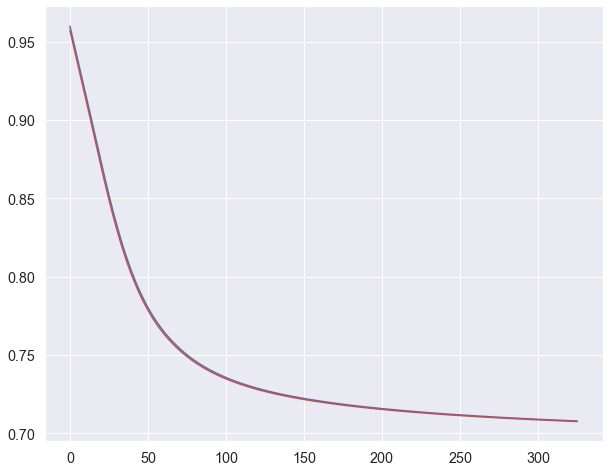

In [113]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

<p> end test </p>

In [19]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 16)
Ytrain pre augmentation (13031, 1)
Xtrain: (24652, 16)
Ytrain (24652, 1)
Xtest (3258, 16)
Ytest (3258, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5867       0.4971        0.6080  0.3597
      2        0.4562       0.4971        0.4528  0.4951
      3        0.3843       0.4971        0.3618  0.2533
      4        0.3384       0.4971        0.3167  0.2521
      5        0.3071       0.4971        0.2889  0.2620
      6        0.2825       0.4971        0.2687  0.2561
      7        0.2642       0.4971        0.2521  0.2526
      8        0.2470       0.4971        0.2378  0.2566
      9        0.2337       0.4971        0.2254  0.2603
     10        0.2225       0.4971        0.2146  0.3126
     11        0.2119       0.4971        0.2053  0.2994
     12        0.2027       0.4971        0.1971  0.3574
     13        0.1950       0.4971        0.1895  0.2836
  

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24859, 16)
Ytrain (24859, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6191       0.4978        0.6285  0.3176
      2        0.4900       0.4978        0.4677  0.3354
      3        0.4113       0.4978        0.3725  0.3112
      4        0.3597       0.4978        0.3272  0.3117
      5        0.3236       0.4978        0.2965  0.3083
      6        0.2938       0.4978        0.2719  0.3209
      7        0.2709       0.4978        0.2512  0.3119
      8        0.2509       0.4978        0.2342  0.3092
      9        0.2348       0.4978        0.2199  0.3826
     10        0.2217       0.4978        0.2078  0.3091
     11        0.2088       0.4978        0.1975  0.3218
     12        0.2001       0.4978        0.1883  0.3121
     13        0.1901       0.4978        0.1802  0.3

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24698, 16)
Ytrain (24698, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5464       0.4986        0.6093  0.2813
      2        0.4392       0.4986        0.4460  0.3540
      3        0.3704       0.4986        0.3523  0.2814
      4        0.3266       0.4986        0.3048  0.2719
      5        0.2943       0.4986        0.2760  0.2740
      6        0.2699       0.4986        0.2558  0.2748
      7        0.2529       0.4986        0.2403  0.2712
      8        0.2362       0.4986        0.2279  0.2744
      9        0.2267       0.4986        0.2173  0.2757
     10        0.2143       0.4986        0.2079  0.2726
     11        0.2064       0.4986        0.1996  0.2792
     12        0.1990       0.4986        0.1924  0.2721
     13        0.1922       0.4986        0.1855  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24735, 16)
Ytrain (24735, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6007       0.4981        0.6358  0.4922
      2        0.4805       0.4981        0.4877  0.4400
      3        0.4087       0.4981        0.3845  0.4496
      4        0.3596       0.4981        0.3322  0.3724
      5        0.3258       0.4981        0.3004  0.6256
      6        0.2995       0.4981        0.2765  0.7422
      7        0.2749       0.4981        0.2566  0.4233
      8        0.2551       0.4981        0.2398  0.4163
      9        0.2378       0.4981        0.2252  0.7502
     10        0.2236       0.4981        0.2126  0.3681
     11        0.2117       0.4981        0.2018  0.3610
     12        0.2029       0.4981        0.1923  0.3544
     13        0.1910       0.4981        0.1839  0.3

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24620, 16)
Ytrain (24620, 1)
Xtest (3257, 16)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7128       0.5002        0.6520  0.3427
      2        0.5483       0.5002        0.5056  0.4170
      3        0.4473       0.5002        0.3988  0.3106
      4        0.3791       0.5002        0.3390  0.3257
      5        0.3342       0.5002        0.3014  0.3235
      6        0.3003       0.5002        0.2743  0.3032
      7        0.2747       0.5002        0.2533  0.3021
      8        0.2552       0.5002        0.2366  0.2934
      9        0.2385       0.5002        0.2228  0.2880
     10        0.2248       0.5002        0.2111  0.2875
     11        0.2123       0.5002        0.2011  0.2946
     12        0.2037       0.5002        0.1924  0.2893
     13        0.1935       0.5002        0.1847  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3650, 16)
Ytrain (3650, 1)
Xtest (558, 16)
Ytest (558, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9120       0.5000        0.7097  0.0437
      2        0.8647       0.5000        0.7091  0.0565
      3        0.8145       0.5000        0.7074  0.0581
      4        0.7745       0.5000        0.7039  0.0552
      5        0.7378       0.5000        0.6979  0.0614
      6        0.7068       0.5000        0.6889  0.0617
      7        0.6692       0.5000        0.6764  0.0676
      8        0.6415       0.5000        0.6606  0.0594
      9        0.6149       0.5000        0.6417  0.0645
     10        0.5774       0.5000        0.6203  0.0594
     11        0.5528       0.5000        0.5971  0.1400
     12        0.5304       0.5000        0.5726  0.0901
     13        0.5104       0.5000        0.5476  0.0609
     14        0.4896       0.5000        0.5228  0.0656
     15        0.4714

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3598, 16)
Ytrain (3598, 1)
Xtest (558, 16)
Ytest (558, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7726       0.5000        0.7076  0.0500
      2        0.7254       0.5000        0.7044  0.0545
      3        0.6776       0.5000        0.6978  0.0611
      4        0.6369       0.5000        0.6868  0.0626
      5        0.5990       0.5000        0.6711  0.0607
      6        0.5613       0.5000        0.6501  0.0640
      7        0.5256       0.5000        0.6237  0.0575
      8        0.5048       0.5000        0.5927  0.0606
      9        0.4777       0.5000        0.5586  0.0617
     10        0.4500       0.5000        0.5234  0.0552
     11        0.4262       0.5000        0.4886  0.0597
     12        0.4090       0.5000        0.4556  0.0618
     13        0.3948       0.5000        0.4251  0.0573


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3599, 16)
Ytrain (3599, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6730       0.5014        0.6883  0.0498
      2        0.6410       0.5014        0.6829  0.0590
      3        0.6055       0.5014        0.6748  0.0591
      4        0.5753       0.5014        0.6634  0.0640
      5        0.5427       0.5014        0.6485  0.0600
      6        0.5202       0.5014        0.6299  0.0575
      7        0.4904       0.5014        0.6076  0.0562
      8        0.4734       0.5014        0.5821  0.0651
      9        0.4525       0.5014        0.5545  0.0679
     10        0.4274       0.5014        0.5259  0.0642
     11        0.4135       0.5014        0.4971  0.0584
     12        0.3973       0.5014        0.4693  0.0582
     13        0.3858       0.5014        0.4432  0.0707


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3604, 16)
Ytrain (3604, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8071       0.5021        0.7095  0.0491
      2        0.7566       0.5021        0.7073  0.0575
      3        0.7127       0.5021        0.7035  0.0655
      4        0.6810       0.5021        0.6969  0.0643
      5        0.6483       0.5021        0.6869  0.0604
      6        0.6141       0.5021        0.6730  0.0679
      7        0.5825       0.5021        0.6549  0.0651
      8        0.5553       0.5021        0.6328  0.0611
      9        0.5400       0.5021        0.6075  0.0641
     10        0.5076       0.5021        0.5801  0.0628
     11        0.4943       0.5021        0.5519  0.0635
     12        0.4743       0.5021        0.5241  0.0682
     13        0.4548       0.5021        0.4973  0.0674


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3602, 16)
Ytrain (3602, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6688       0.4993        0.6705  0.0532
      2        0.6349       0.4993        0.6603  0.0568
      3        0.6006       0.4993        0.6473  0.0676
      4        0.5659       0.4993        0.6304  0.0658
      5        0.5319       0.4993        0.6093  0.0610
      6        0.5032       0.4993        0.5840  0.1472
      7        0.4954       0.4993        0.5550  0.0707
      8        0.4684       0.4993        0.5234  0.0625
      9        0.4396       0.4993        0.4910  0.0621
     10        0.4218       0.4993        0.4592  0.0730
     11        0.4067       0.4993        0.4296  0.0721
     12        0.3904       0.4993        0.4028  0.0726
     13        0.3823       0.4993        0.3793  0.0744


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25205, 17)
Ytrain (25205, 1)
Xtest (3236, 17)
Ytest (3236, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7819       0.4981        0.7119  0.3222
      2        0.7460       0.4981        0.6929  0.3222
      3        0.7129       0.4981        0.6762  0.3132
      4        0.6899       0.4981        0.6553  0.3710
      5        0.6666       0.4981        0.6341  0.2824
      6        0.6420       0.4981        0.6144  0.2799
      7        0.6261       0.4981        0.5957  0.2935
      8        0.6063       0.4981        0.5781  0.2839
      9        0.5920       0.4981        0.5619  0.2867
     10        0.5740       0.4981        0.5468  0.2839
     11        0.5605       0.4981        0.5328  0.2839
     12        0.5458       0.4981        0.5199  0.2826
     13        0.5326       0.4981        0.5082  0.2879
     14        0.5222       0.4981        0.4972  0.2838
     15        0.

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25122, 17)
Ytrain (25122, 1)
Xtest (3236, 17)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6860       0.4981        0.6630  0.2531
      2        0.6566       0.4981        0.6290  0.2685
      3        0.6301       0.4981        0.6045  0.2593
      4        0.6064       0.4981        0.5793  0.2603
      5        0.5868       0.4981        0.5593  0.2748
      6        0.5670       0.4981        0.5421  0.2606
      7        0.5514       0.4981        0.5267  0.2592
      8        0.5360       0.4981        0.5128  0.2564
      9        0.5215       0.4981        0.4998  0.2688
     10        0.5068       0.4981        0.4879  0.2612
     11        0.4975       0.4981        0.4766  0.2575
     12        0.4867       0.4981        0.4661  0.3398
     13        0.4750       0.4981        0.4561  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25265, 17)
Ytrain (25265, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6727       0.4967        0.6672  0.2854
      2        0.6590       0.4967        0.6421  0.2891
      3        0.6469       0.4967        0.6254  0.2887
      4        0.6349       0.4967        0.6146  0.3238
      5        0.6222       0.4967        0.6037  0.3592
      6        0.6145       0.4967        0.5934  0.2862
      7        0.6025       0.4967        0.5837  0.2940
      8        0.5932       0.4967        0.5743  0.2873
      9        0.5855       0.4967        0.5654  0.2868
     10        0.5756       0.4967        0.5568  0.2815
     11        0.5674       0.4967        0.5485  0.2832
     12        0.5598       0.4967        0.5402  0.2804
     13        0.5512       0.4967        0.5320  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25263, 17)
Ytrain (25263, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9559       0.4967        0.7711  0.2742
      2        0.9141       0.4967        0.8133  0.2854
      3        0.8760       0.4967        0.8184  0.2833
      4        0.8426       0.4967        0.7934  0.2749
      5        0.8095       0.4967        0.7653  0.2744
      6        0.7819       0.4967        0.7391  0.2891
      7        0.7583       0.4967        0.7148  0.2882
      8        0.7308       0.4967        0.6920  0.2940
      9        0.7077       0.4967        0.6707  0.3710
     10        0.6881       0.4967        0.6513  0.3269
     11        0.6663       0.4967        0.6332  0.3390
     12        0.6523       0.4967        0.6160  0.3624
     13        0.6361       0.4967        0.6000  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25220, 17)
Ytrain (25220, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8753       0.4970        0.7927  0.2882
      2        0.8465       0.4970        0.8112  0.2925
      3        0.8193       0.4970        0.7835  0.2832
      4        0.7959       0.4970        0.7554  0.2888
      5        0.7717       0.4970        0.7319  0.3651
      6        0.7471       0.4970        0.7110  0.2823
      7        0.7302       0.4970        0.6921  0.2843
      8        0.7095       0.4970        0.6749  0.2887
      9        0.6921       0.4970        0.6592  0.2913
     10        0.6754       0.4970        0.6446  0.2901
     11        0.6603       0.4970        0.6309  0.2824
     12        0.6466       0.4970        0.6179  0.2813
     13        0.6364       0.4970        0.6055  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3799, 17)
Ytrain (3799, 1)
Xtest (535, 17)
Ytest (535, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6270       0.4947        0.6980  0.0433
      2        0.6241       0.4947        0.6972  0.0485
      3        0.6232       0.4947        0.6950  0.0691
      4        0.6145       0.4947        0.6903  0.0607
      5        0.6166       0.4947        0.6830  0.0563
      6        0.6151       0.4947        0.6730  0.0593
      7        0.6128       0.4947        0.6614  0.0580
      8        0.6100       0.4947        0.6492  0.0610
      9        0.6079       0.4947        0.6370  0.0591
     10        0.6074       0.4947        0.6254  0.0557
     11        0.6018       0.4947        0.6147  0.0582
     12        0.6031       0.4947        0.6054  0.0543
     13        0.6028       0.4947        0.5976  0.0558
     14        0.5995       0.4947        0.5913  0.1334
     15        0.5935

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3808, 17)
Ytrain (3808, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6773       0.4934        0.6917  0.0430
      2        0.6701       0.4934        0.6879  0.0528
      3        0.6696       0.4934        0.6821  0.0619
      4        0.6689       0.4934        0.6744  0.0536
      5        0.6696       0.4934        0.6651  0.0565
      6        0.6619       0.4934        0.6550  0.0572
      7        0.6596       0.4934        0.6452  0.0546
      8        0.6565       0.4934        0.6367  0.0608
      9        0.6479       0.4934        0.6299  0.0582
     10        0.6512       0.4934        0.6248  0.0590
     11        0.6497       0.4934        0.6212  0.0575
     12        0.6451       0.4934        0.6185  0.0605
     13        0.6399       0.4934        0.6163  0.0577


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3834, 17)
Ytrain (3834, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9472       0.4928        0.7233  0.0445
      2        0.9383       0.4928        0.7403  0.0537
      3        0.9301       0.4928        0.7592  0.0558
      4        0.9204       0.4928        0.7793  0.0563
      5        0.9183       0.4928        0.7993  0.0608
      6        0.9118       0.4928        0.8179  0.0604
      7        0.9007       0.4928        0.8339  0.0568
      8        0.9019       0.4928        0.8463  0.0591
      9        0.8943       0.4928        0.8539  0.0586
     10        0.8724       0.4928        0.8570  0.0629
     11        0.8796       0.4928        0.8568  0.0562
     12        0.8796       0.4928        0.8541  0.1304
     13        0.8634       0.4928        0.8497  0.0624


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3807, 17)
Ytrain (3807, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8507       0.4934        0.7097  0.0460
      2        0.8407       0.4934        0.7178  0.0594
      3        0.8359       0.4934        0.7270  0.0577
      4        0.8273       0.4934        0.7362  0.0591
      5        0.8260       0.4934        0.7445  0.0593
      6        0.8134       0.4934        0.7511  0.0619
      7        0.8126       0.4934        0.7554  0.0563
      8        0.8008       0.4934        0.7573  0.0566
      9        0.8011       0.4934        0.7571  0.0686
     10        0.7916       0.4934        0.7553  0.0578
     11        0.7934       0.4934        0.7527  0.0618
     12        0.7849       0.4934        0.7495  0.0643
     13        0.7807       0.4934        0.7459  0.0564


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3810, 17)
Ytrain (3810, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8162       0.4934        0.7158  0.0478
      2        0.8037       0.4934        0.7184  0.0594
      3        0.8071       0.4934        0.7223  0.0635
      4        0.8011       0.4934        0.7256  0.0599
      5        0.8005       0.4934        0.7284  0.0694
      6        0.7924       0.4934        0.7306  0.0614
      7        0.7836       0.4934        0.7322  0.0645
      8        0.7788       0.4934        0.7329  0.0590
      9        0.7689       0.4934        0.7330  0.0601
     10        0.7785       0.4934        0.7325  0.0641
     11        0.7704       0.4934        0.7312  0.0606
     12        0.7616       0.4934        0.7294  0.0647
     13        0.7513       0.4934        0.7272  0.0595


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [22]:
ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.962099,0.930272,0.960251,0.911885,0.954903,0.943882
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.162908,0.154381,0.154344,0.159095,0.124901,0.151126


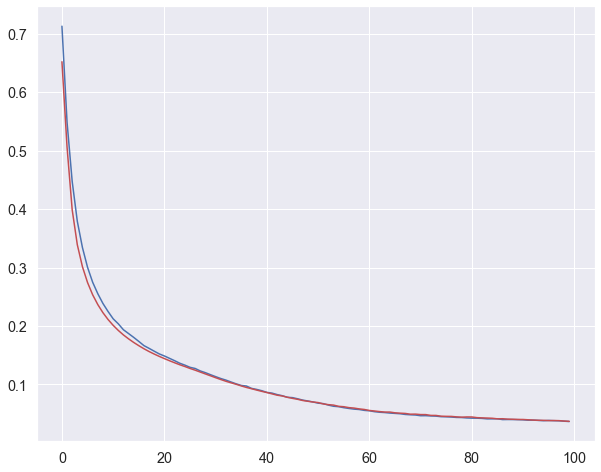

In [23]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [24]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.946586,0.973461,0.970628,0.957593,0.974287,0.964511
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.285904,0.224184,0.228186,0.229569,0.237044,0.240977


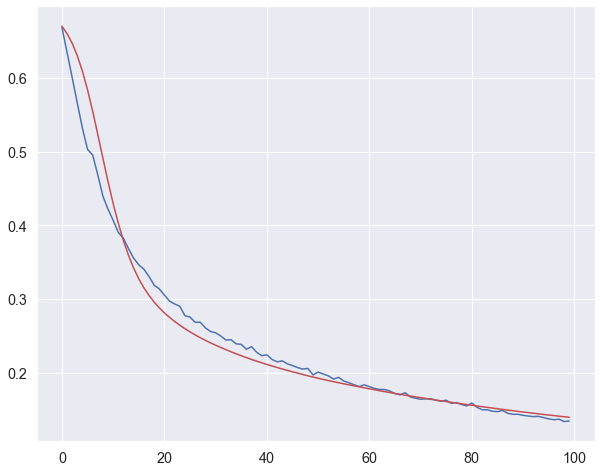

In [25]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [26]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.976597,0.976585,0.974879,0.964429,0.974862,0.973470
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.192537,0.185733,0.181788,0.221870,0.234773,0.203340


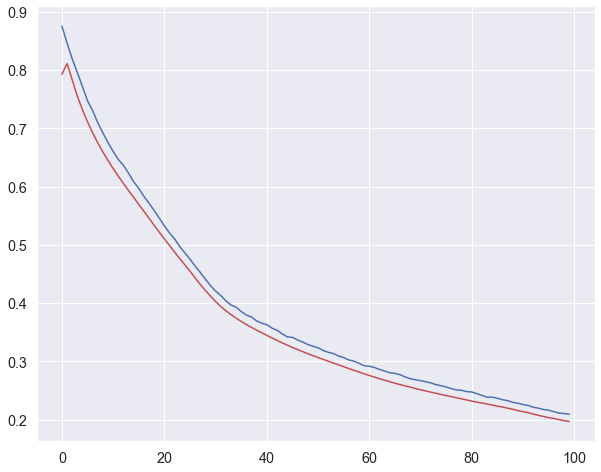

In [27]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [28]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.926083,0.943965,0.900711,0.929963,0.947466,0.929637
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.475706,0.470456,0.456826,0.529660,0.462567,0.479043


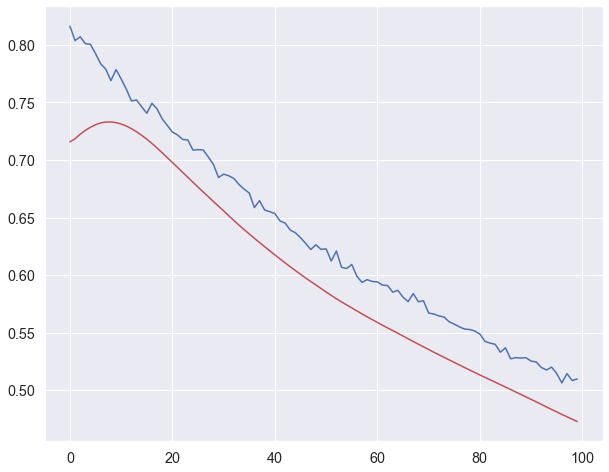

In [29]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [30]:
def propensity_score_functANN(dataset,model,dataset2):
    
    dataset2.columns = dataset2.columns.str.strip() 
    if 're74' in dataset2.columns: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [31]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab)



In [34]:
nswPsid_lalonde_ps_ANN

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.192784,-1.432020
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.013972,-4.256645
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.036933,-3.261008
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.356809,-0.589240
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.085036,-2.375816
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.014485,-4.220045
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.955481,3.066306
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.054625,-2.851092
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.012655,-4.356981


In [185]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN.csv')

## Bar plots of model performance

In [247]:
ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.963238,0.952342,0.955303,0.946844,0.959964,0.955538
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.180009,0.204386,0.178355,0.156891,0.185038,0.180936


In [248]:
# Average accuracy
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

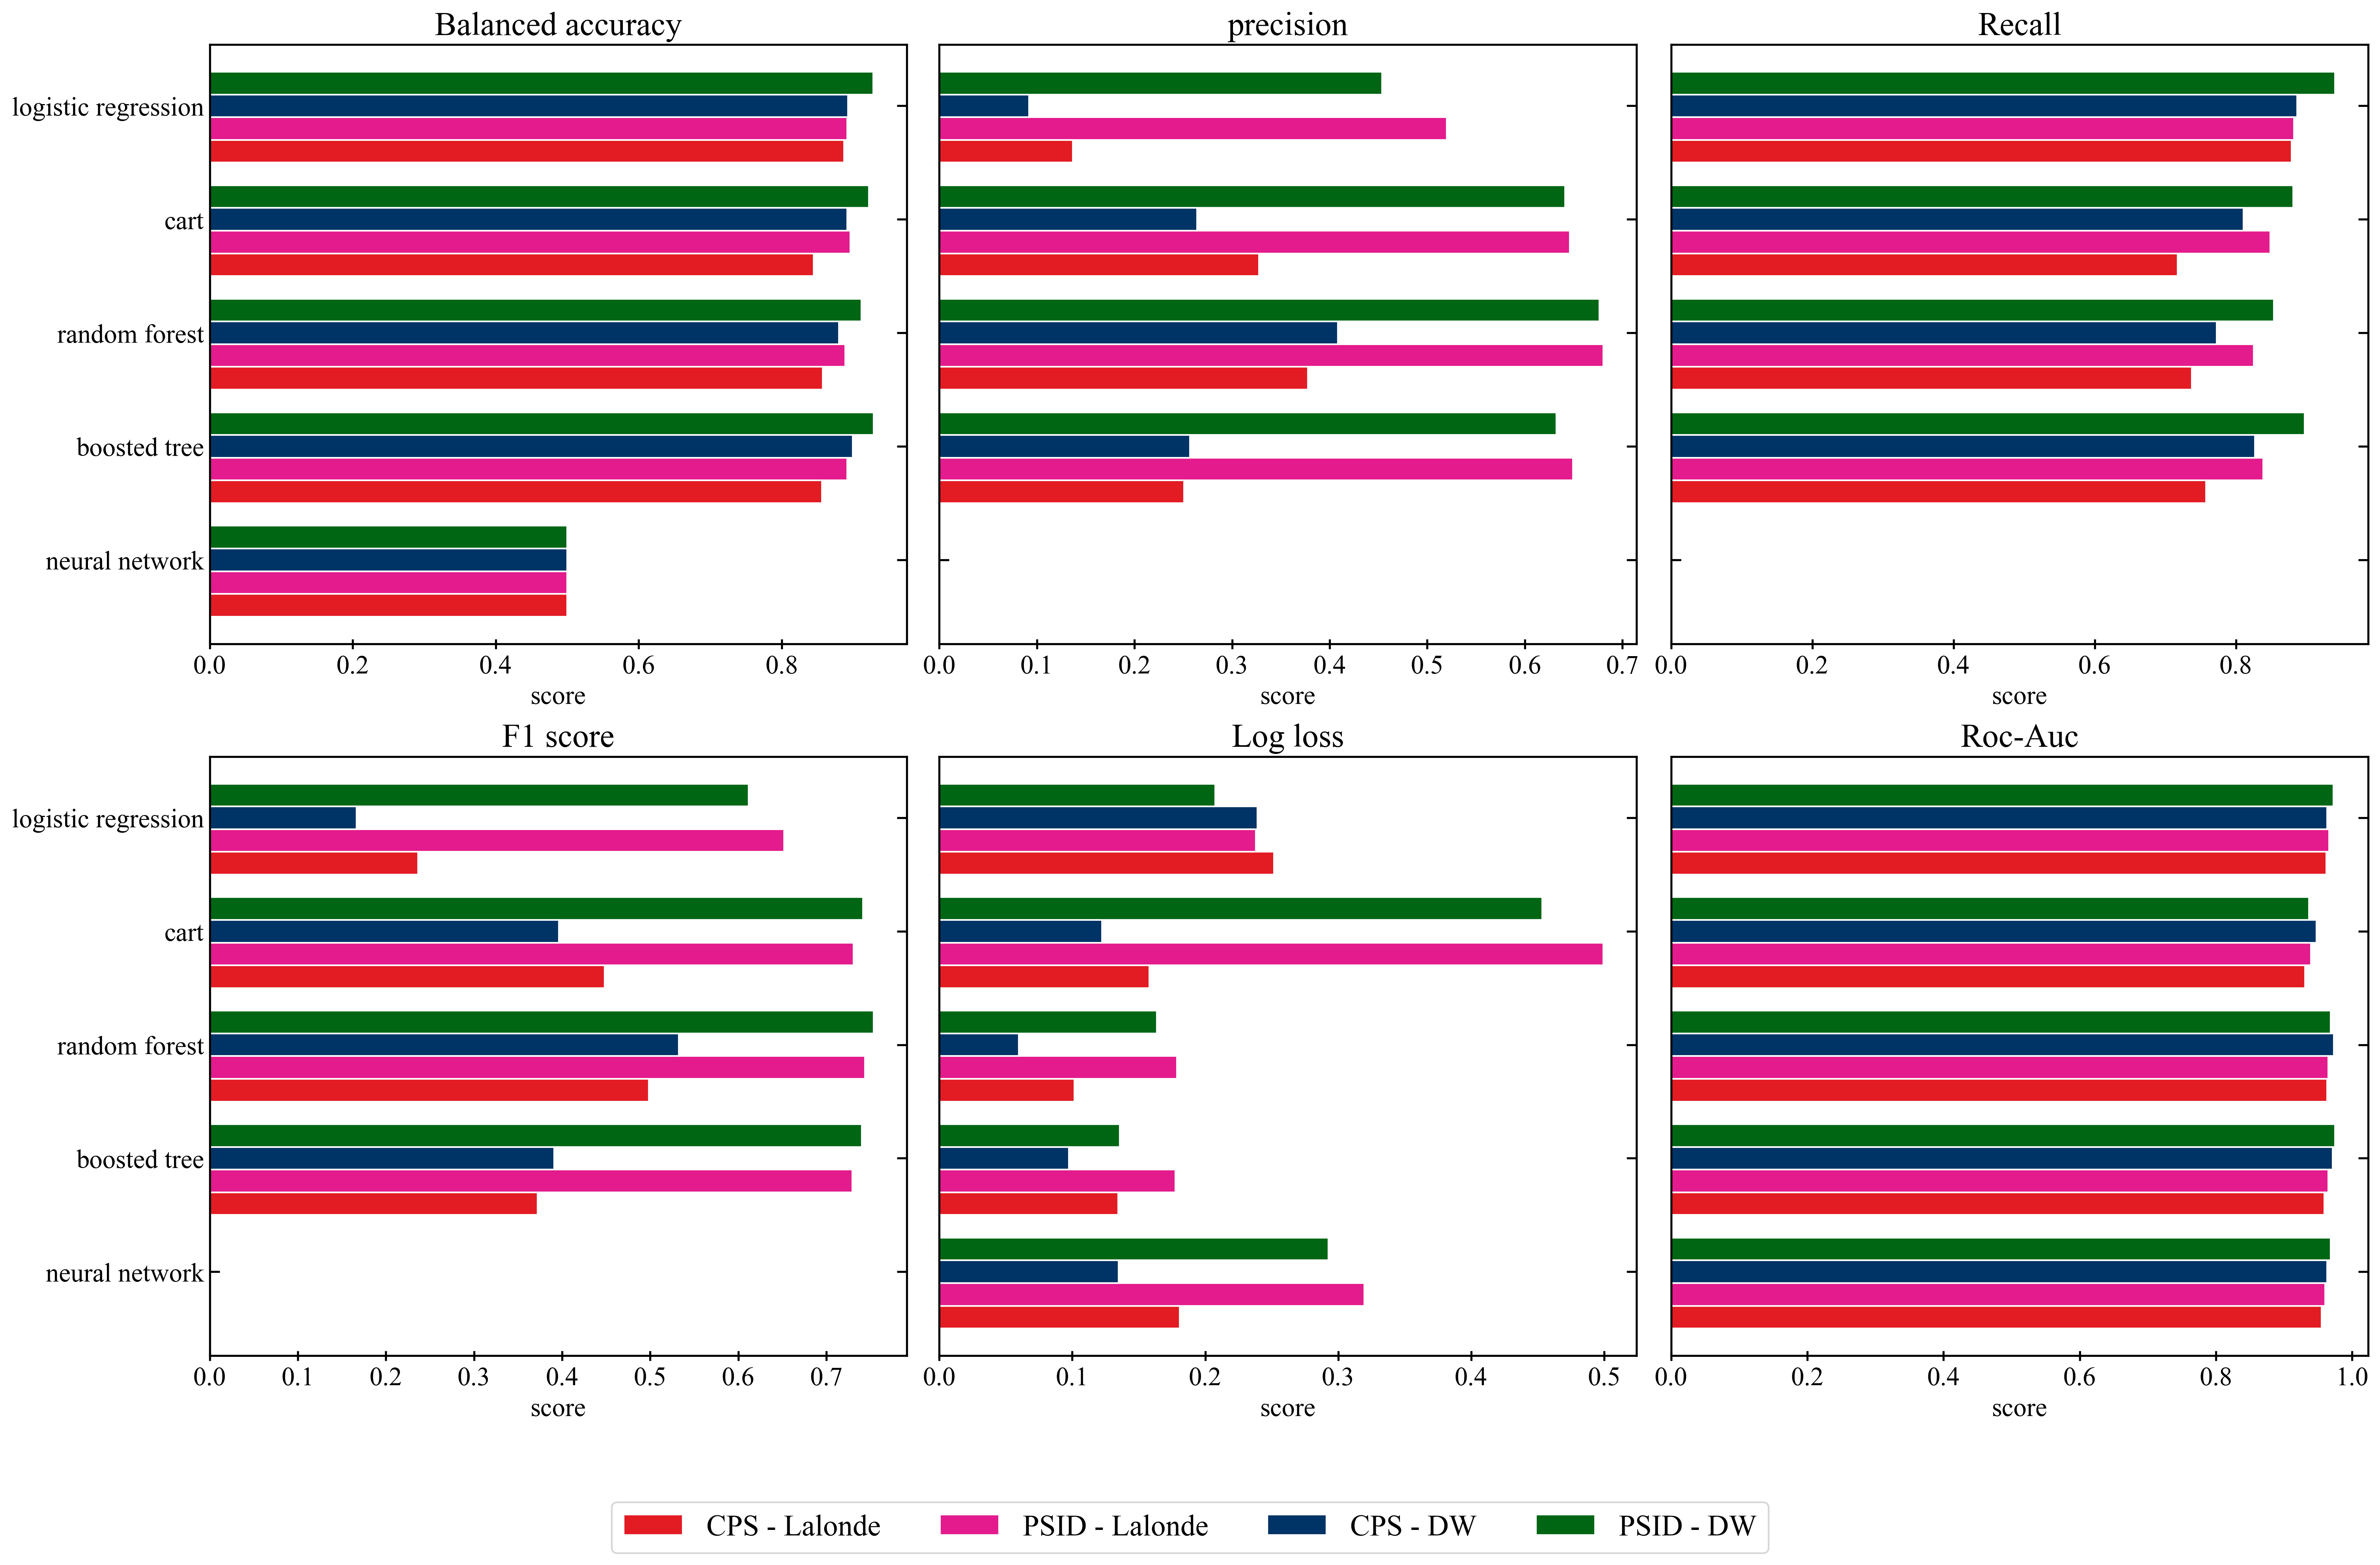

In [257]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#E31B23" # CPS lalonde
colour2 = "#e31b8c" # PSID lalonde
colour3 = "#003366" # CPS dehwab
colour4 = "#006614" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig8_training_evaluation_averages.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [72]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [73]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    

In [74]:

# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 

# covariates used in each mdoel 
logit_vars = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
logit_vars2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u74','u75','educ_re75']
tree_vars = ['treat','age','education*','black','hispanic','married','nodegree','re75']
tree_vars2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
ann_vars = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13','education_14', 'education_15', 'education_16', 'education_17']
ann_vars2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12',  'education_13', 'education_14', 'education_15', 'education_16', 'education_17']
continuos_vars = ['ageboxcox','lnre75'] 
continuos_vars2= ['ageboxcox','lnre74','lnre75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_22306/3253230798.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_22306/3253230798.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn

In [75]:
# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

In [76]:
logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:16:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [77]:
logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:21:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [80]:
logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:25:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [78]:
logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:21:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [81]:
# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


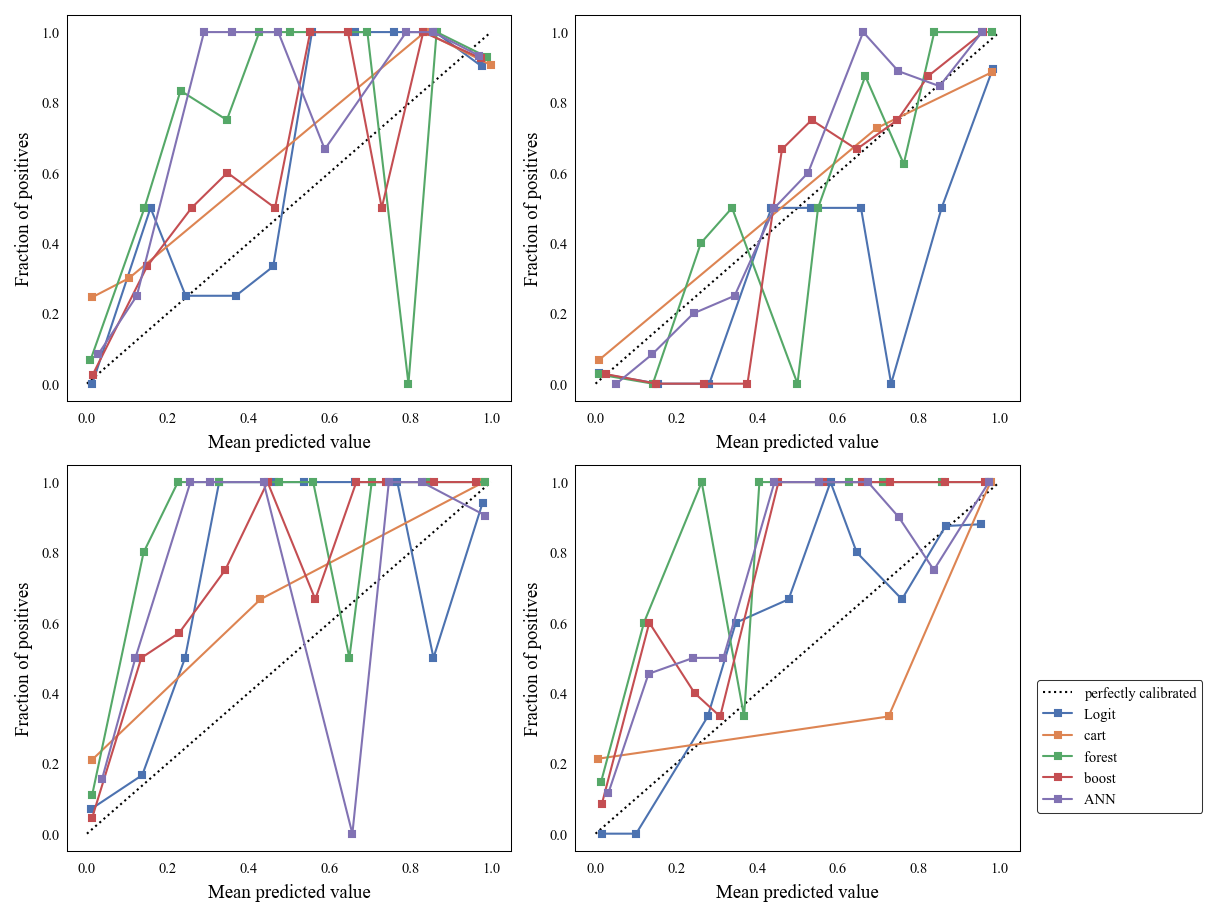

In [85]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,6))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')


marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')


plt.legend(loc=(1.04, 0.1))
plt.show()

# Further matching 

In [ ]:





plt.barh(boston.feature_names, rf.feature_importances_)

## Box plots

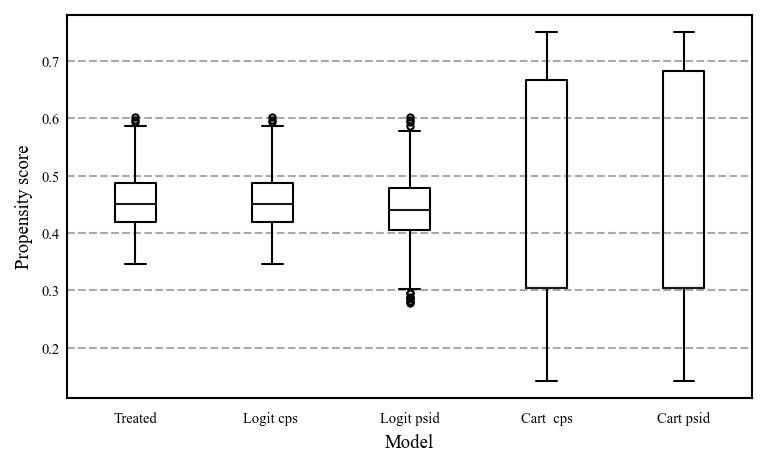

In [120]:
# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()